In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [78]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [79]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [80]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [81]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[1, 2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(data, group_col='city', target_col=weather_columns, lags=[5, 6])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

data = data.dropna().reset_index(drop=True)

In [82]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging',
                   'cases_per_100k', 'nearby_cases_weighted']
# Include lagged variables in the scaling process
lagged_vars = [col for col in data.columns if any(lag in col for lag in ['_lag1', '_lag2', '_lag5', '_lag6'])]
scaler_vars = continuous_vars + lagged_vars
data[scaler_vars] = feature_scaler.fit_transform(data[scaler_vars])

# Scale the target variable
scaled_cases = target_scaler.fit_transform(data[['cases']])
data['scaled_cases'] = scaled_cases

In [83]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 202052)]
test_data = data[(data['week'] > 202052)]

columns_exclude = ['date', 'cases', 'scaled_cases', 'geocode', 'lat', 'long', 'population', 'cases_per_100k', 'year', 'month']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['scaled_cases']
X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
y_test = test_data['scaled_cases']

In [84]:
from sklearn.preprocessing import LabelEncoder

# Ensure you're working with a copy of the DataFrame if necessary
X_train = X_train.copy()  # If it's a slice, we create a new copy
X_test = X_test.copy()    # Same here

# Step 1: Encode the city column
label_encoder = LabelEncoder()
X_train['city_encoded'] = label_encoder.fit_transform(X_train['city'])
X_test['city_encoded'] = label_encoder.transform(X_test['city'])

# Step 2: Drop the original city column
X_train = X_train.drop(columns=['city'])
X_test = X_test.drop(columns=['city'])

In [85]:
# Step 6: Prepare LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [86]:
# Step 7: Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 8: Train the model with early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions and evaluate
scaled_predictions = model.predict(X_test, num_iteration=model.best_iteration)
# Inverse transform predictions to original scale
y_pred = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

# Step 10: Save the model
model.save_model('lightgbm_dengue_model.txt')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.410788	valid_1's rmse: 0.0196977
Early stopping, best iteration is:
[131]	training's rmse: 0.362137	valid_1's rmse: 0.0193019


Top 10 Most Important Features:
                  Feature  Importance
19             cases_lag1         907
20             cases_lag2         519
17               week_sin         117
0                    week         116
8             vim_monthly         110
1               tempe_min         105
5                temp_avg         101
7                     vim         101
13  nearby_cases_weighted          94
18               week_cos          86


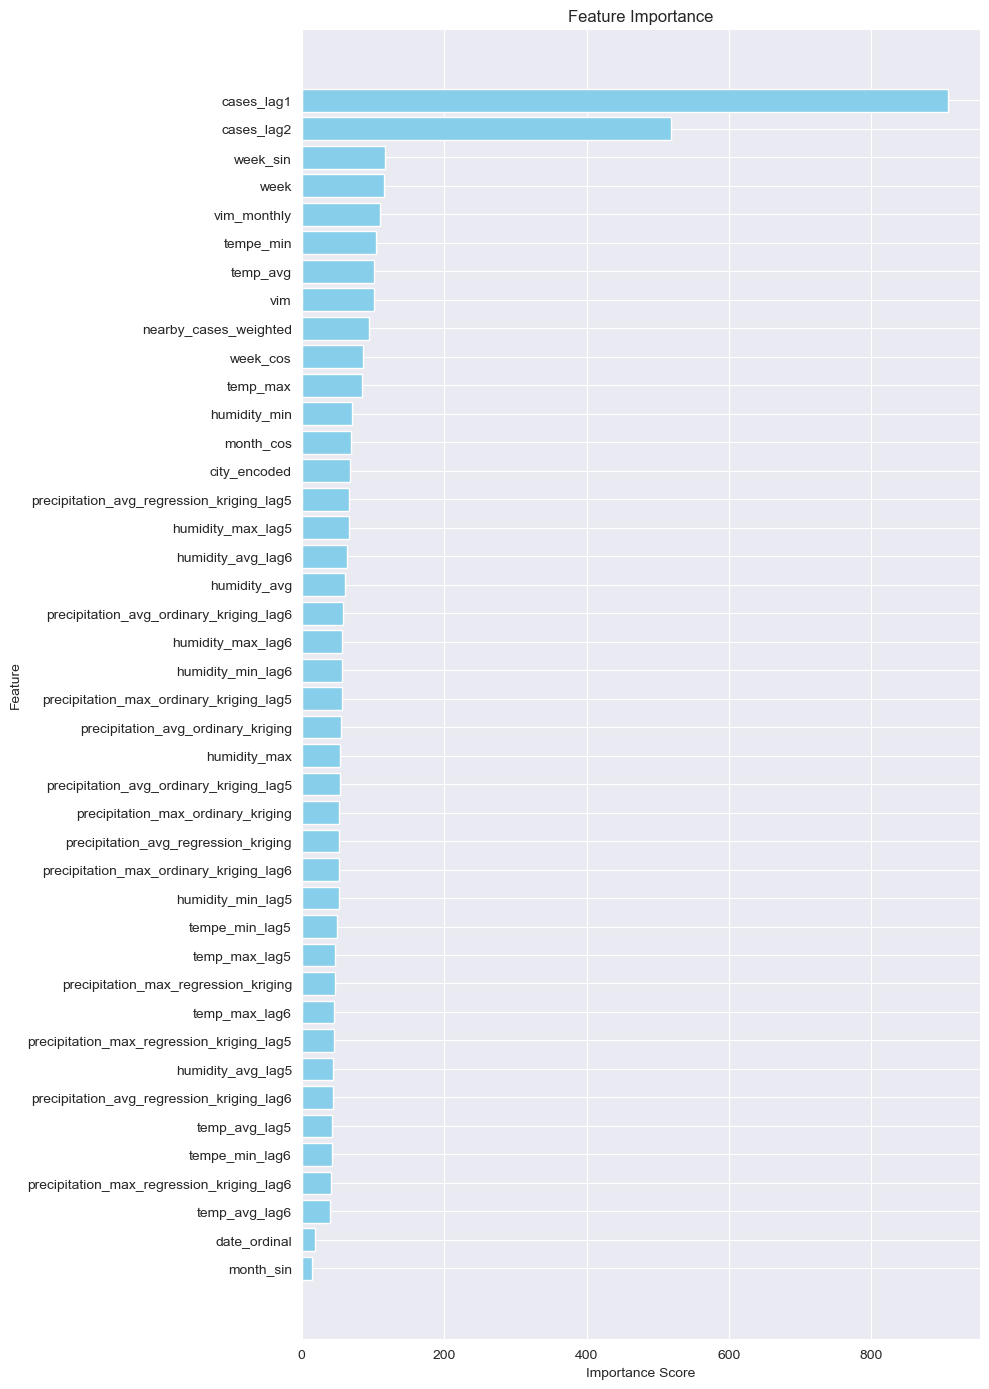

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()


RMSE: 4.040689941356105


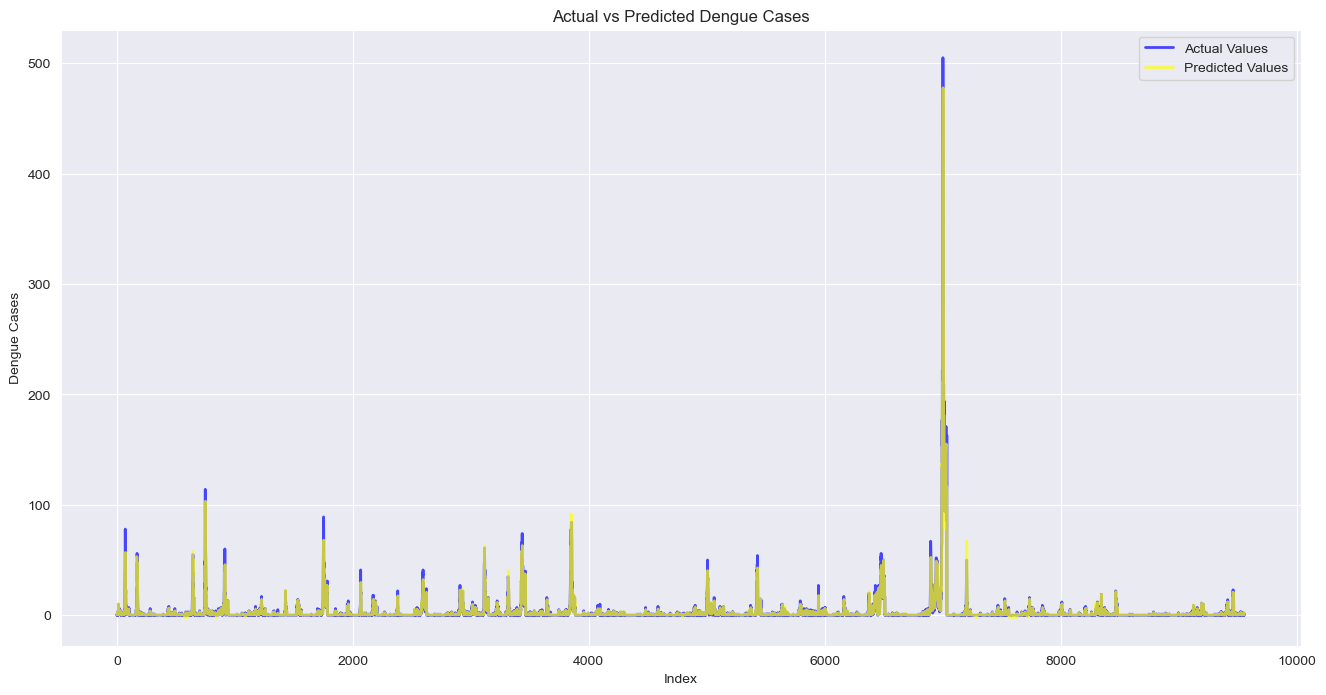

In [88]:
# Step 1: Reshape the actual target values to match the shape of predictions
y_actual = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse}')

# Step 2: Plot the graph
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Values', color='yellow', alpha=0.7, linewidth=2)
plt.xlabel('Index')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()

City: 0, RMSE: 5.48659118107944


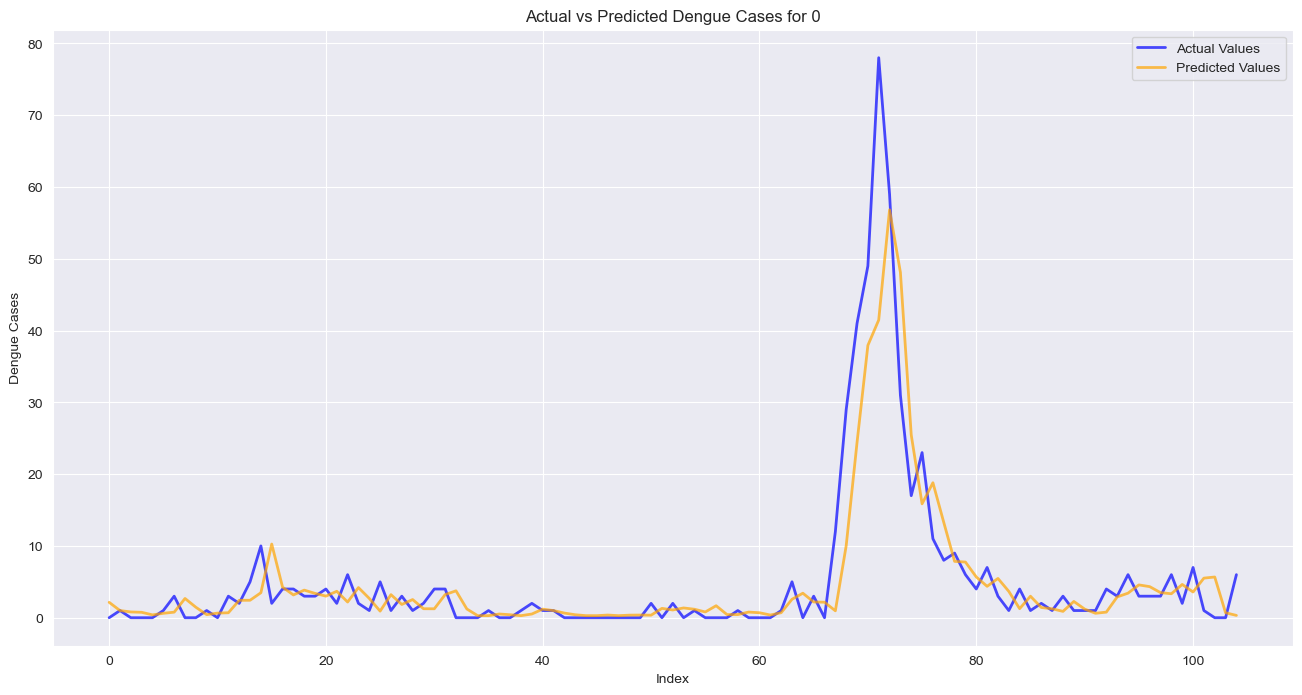

City: 1, RMSE: 5.092156051377557


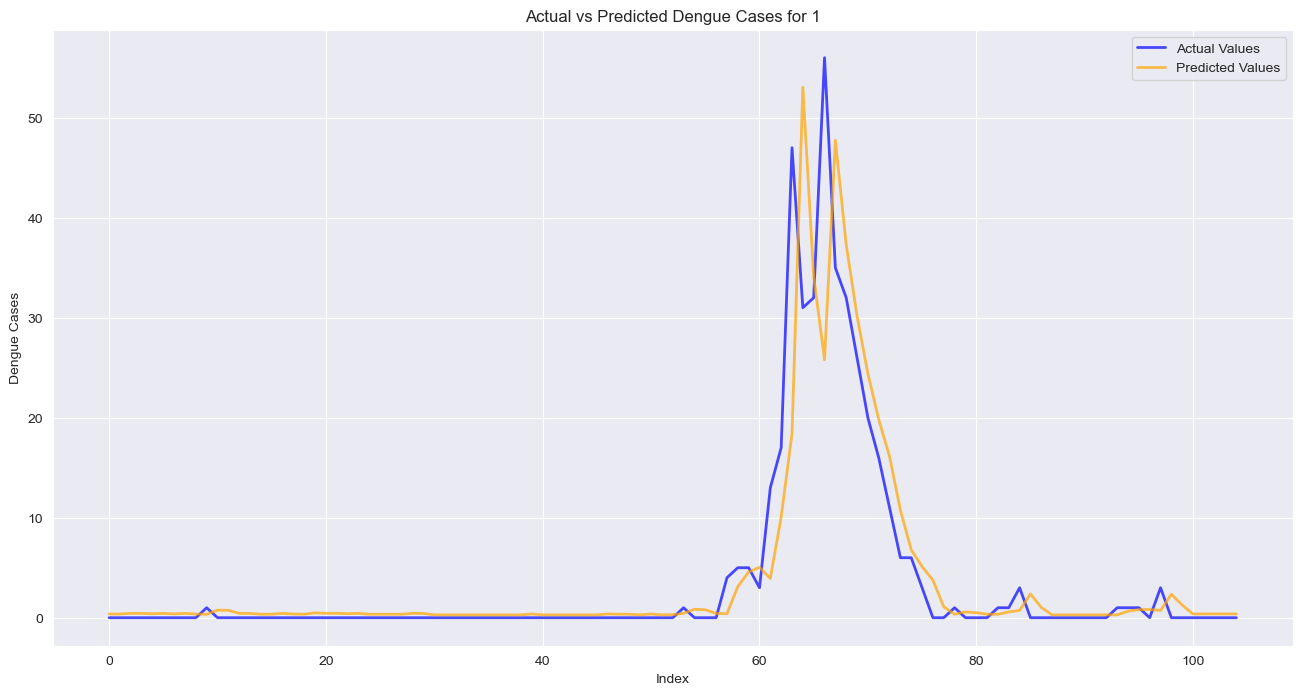

City: 6, RMSE: 4.862304629821778


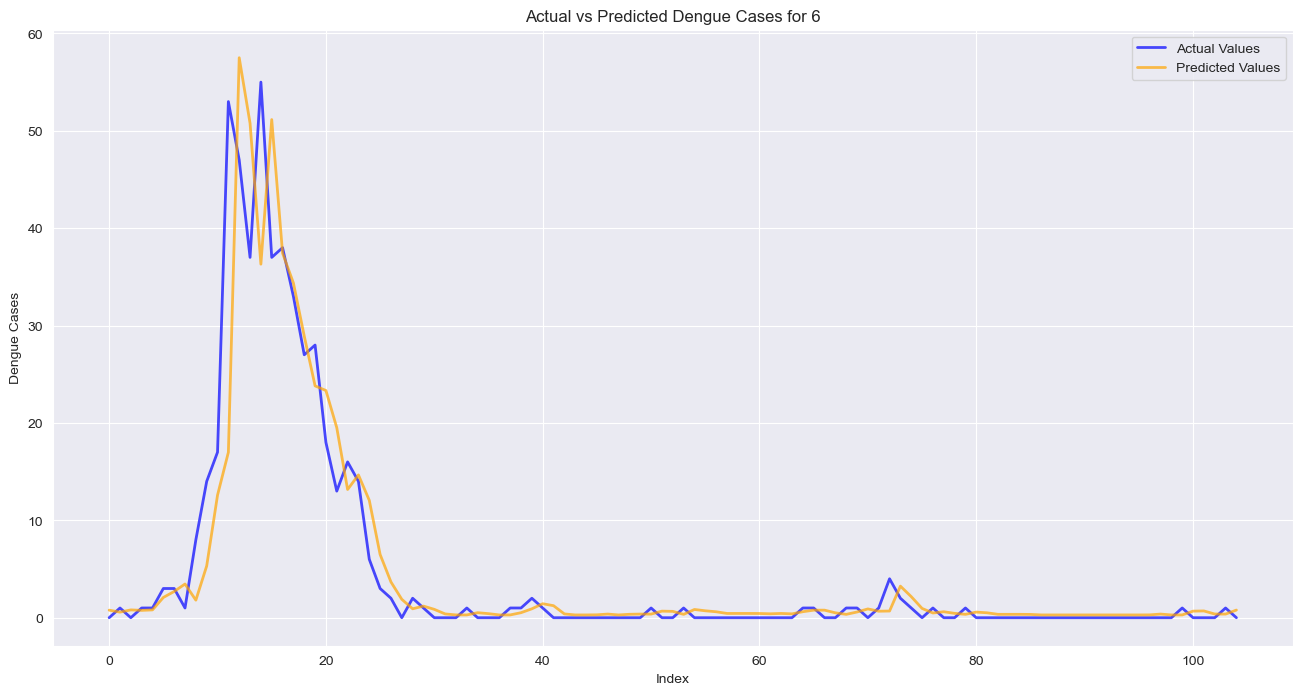

City: 7, RMSE: 8.694854211488611


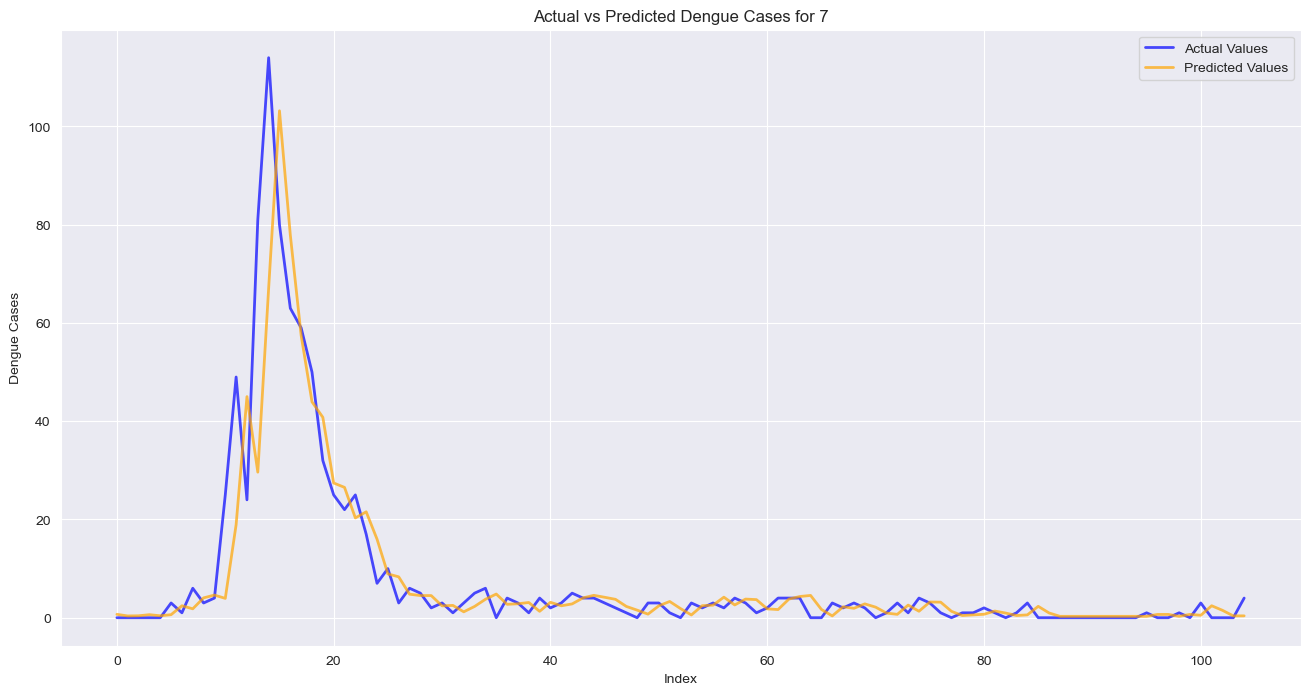

City: 8, RMSE: 6.007425872005499


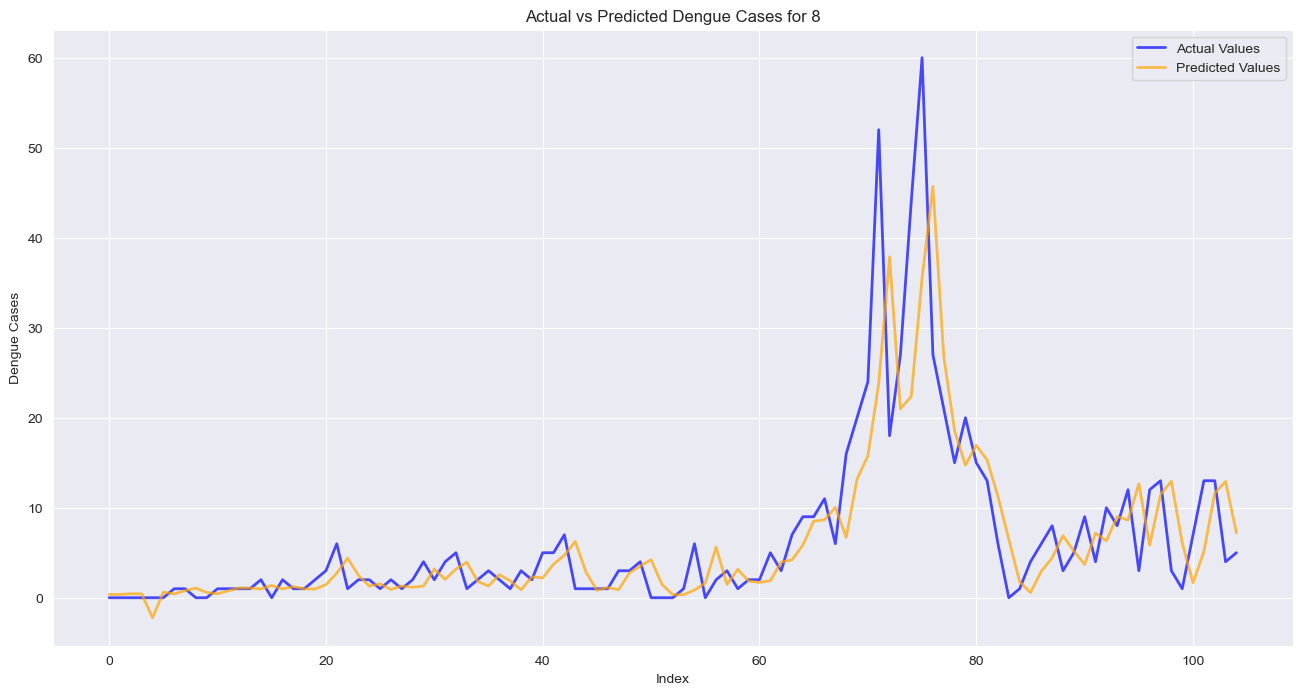

City: 11, RMSE: 2.0458411401202317


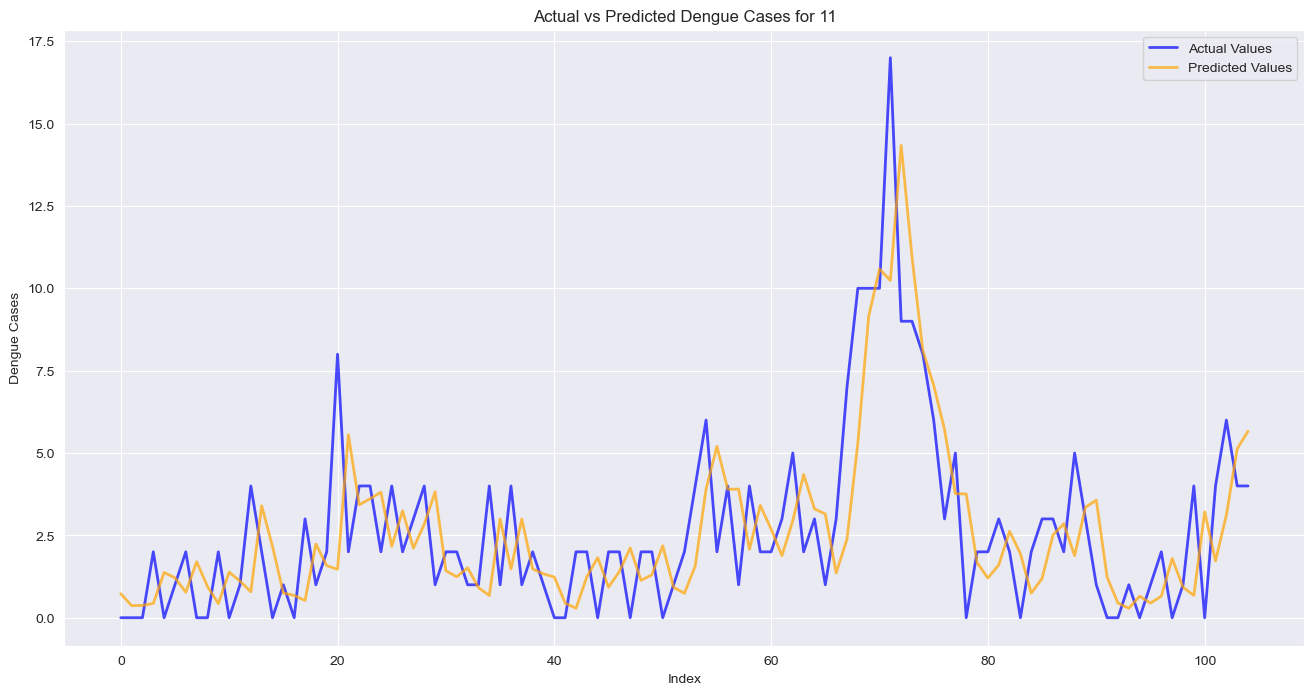

City: 13, RMSE: 2.076830808869419


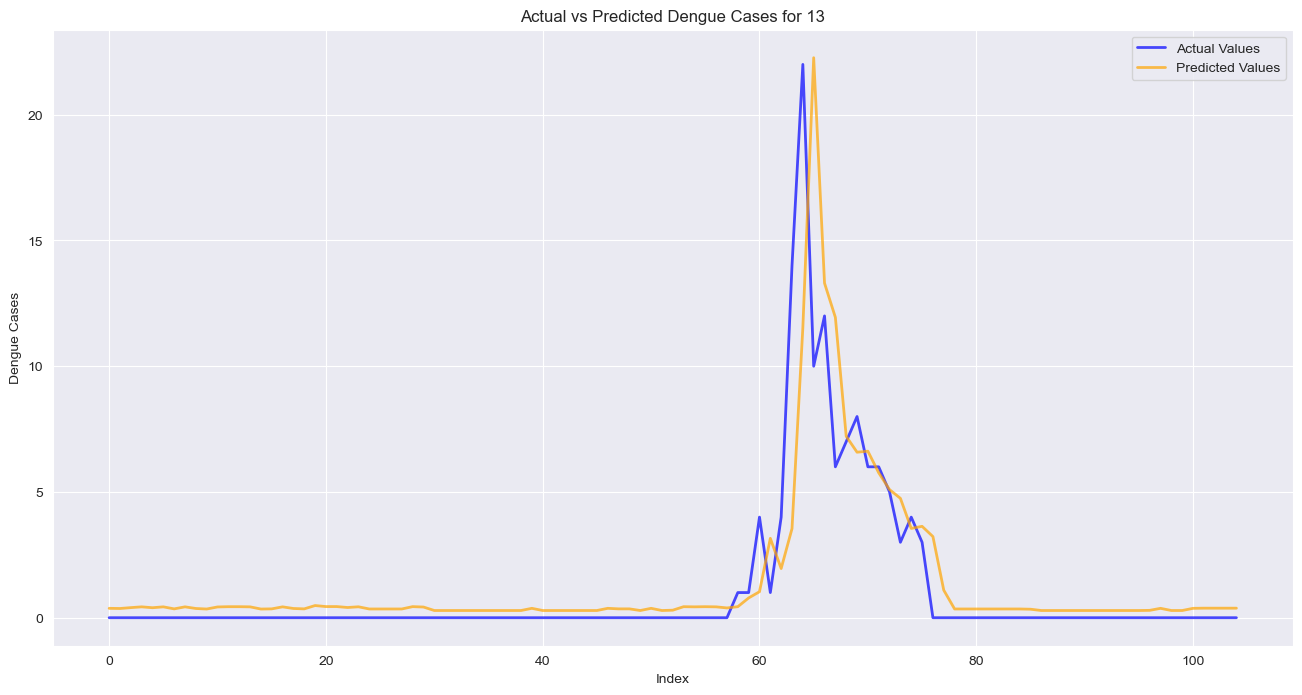

City: 16, RMSE: 2.058051065412346


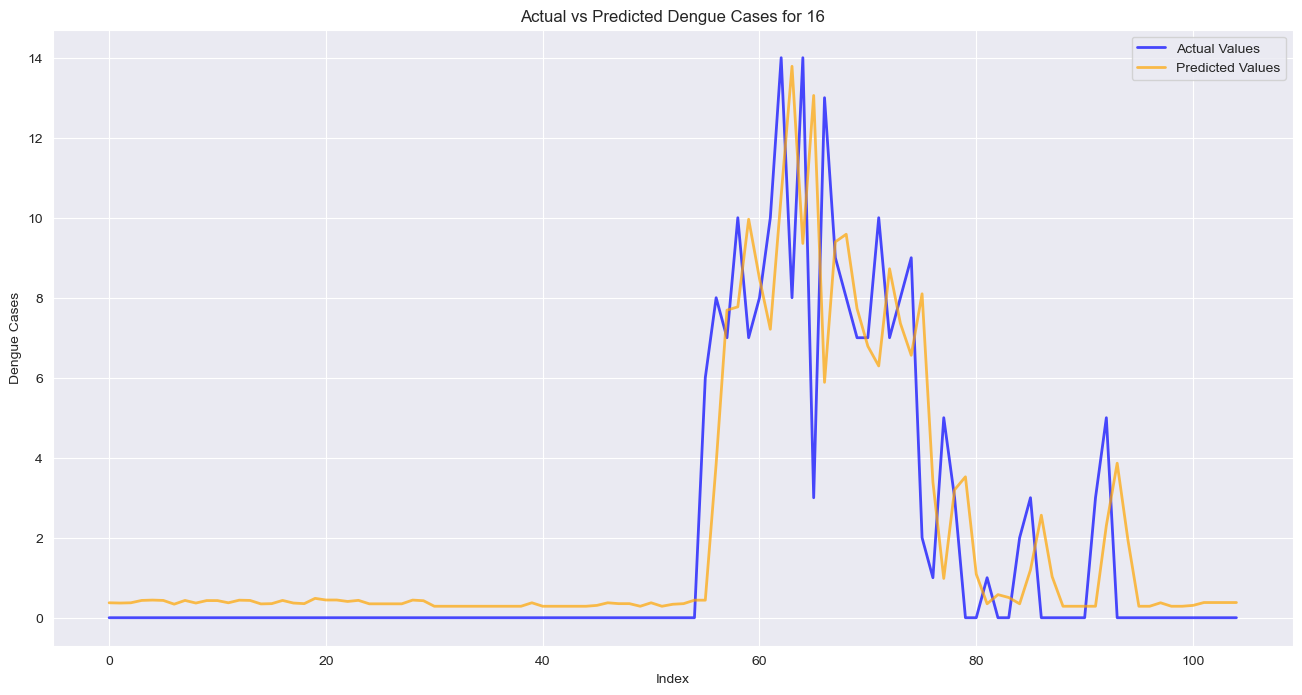

City: 14, RMSE: 6.64901982571872


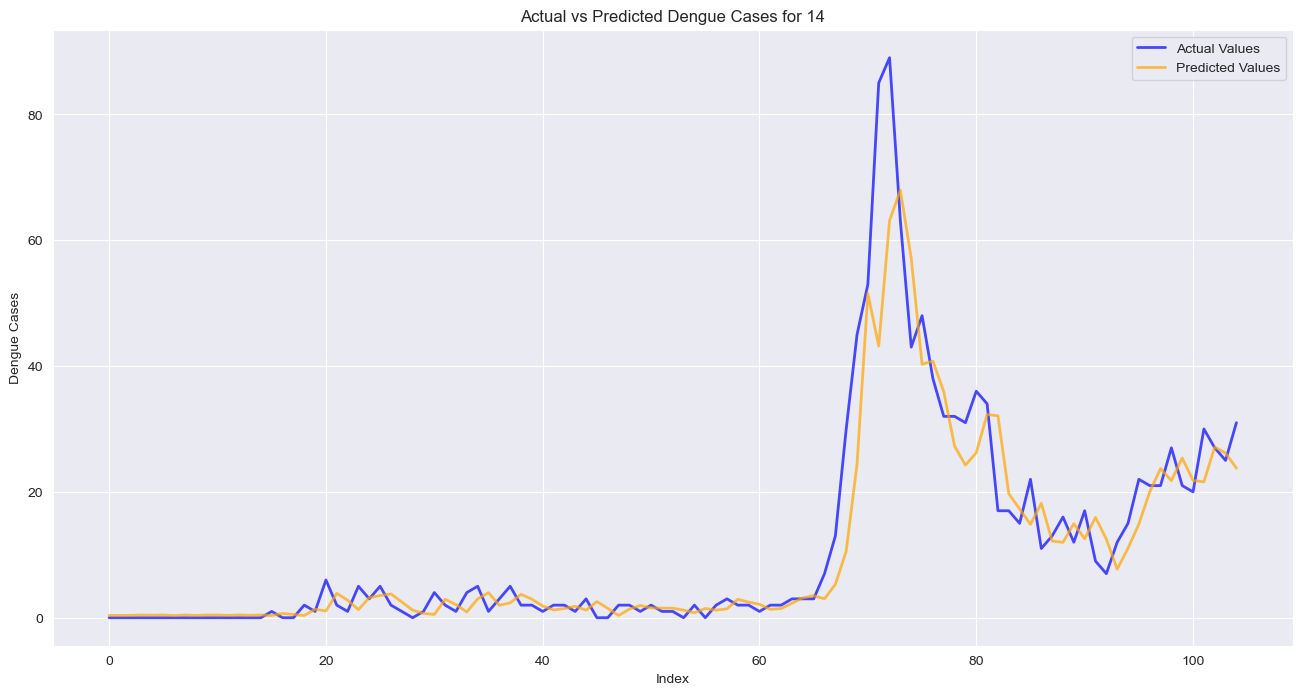

City: 17, RMSE: 1.7545672936036745


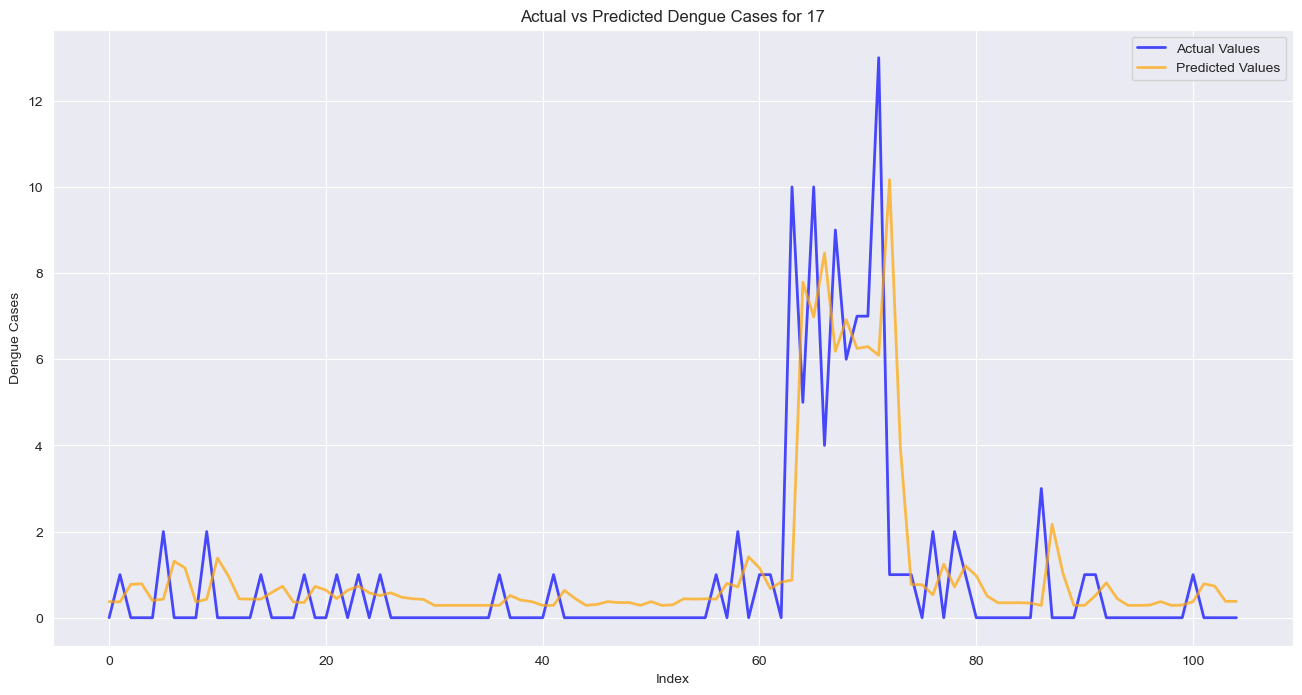

City: 18, RMSE: 3.3711479156473643


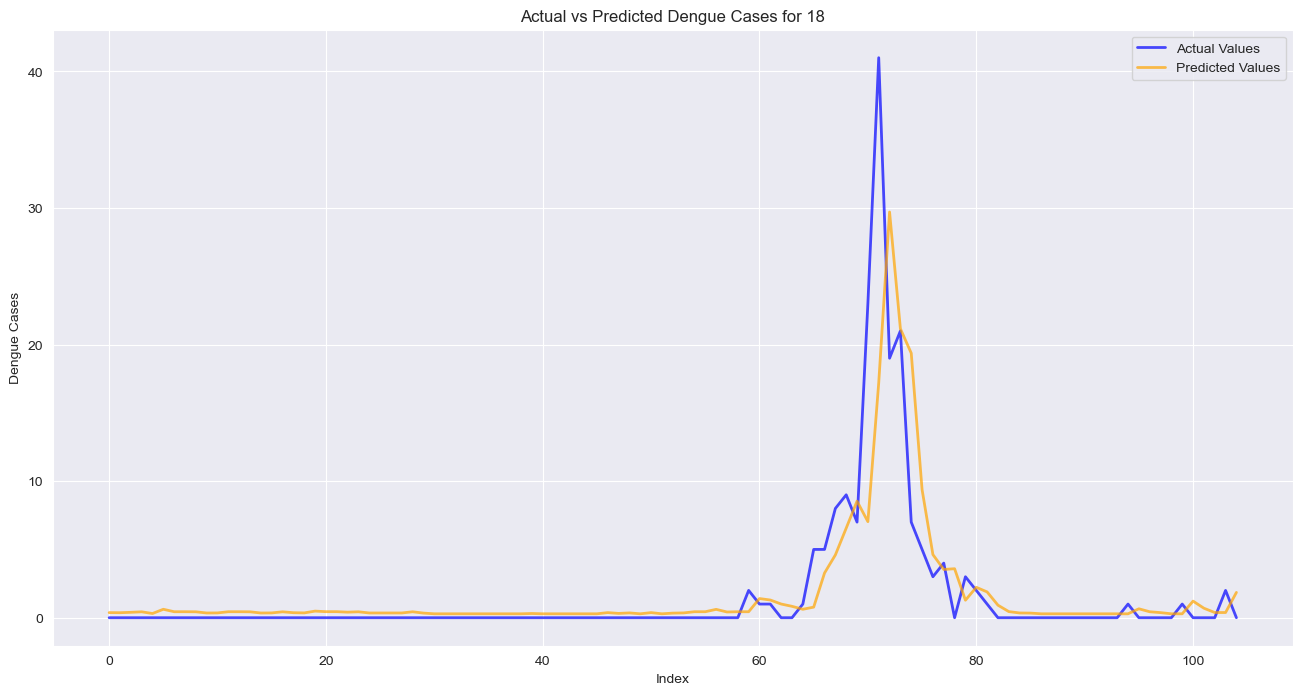

City: 19, RMSE: 2.901782477608602


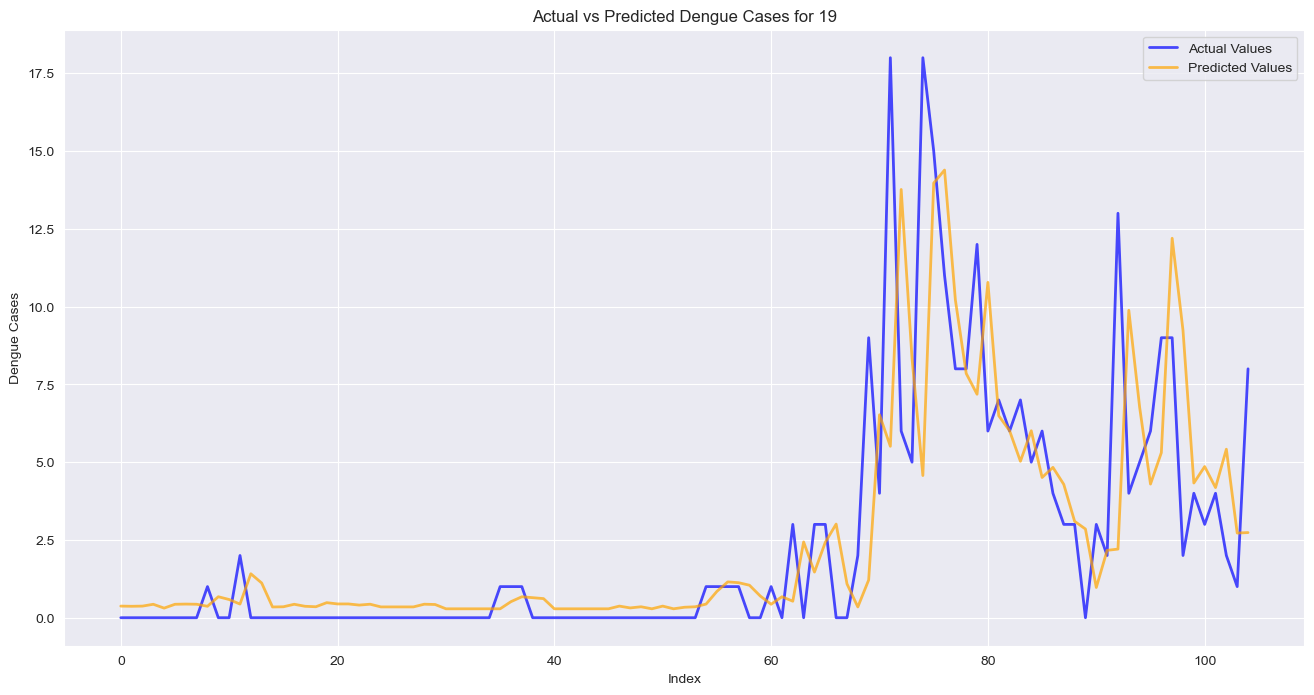

City: 22, RMSE: 1.942053501301113


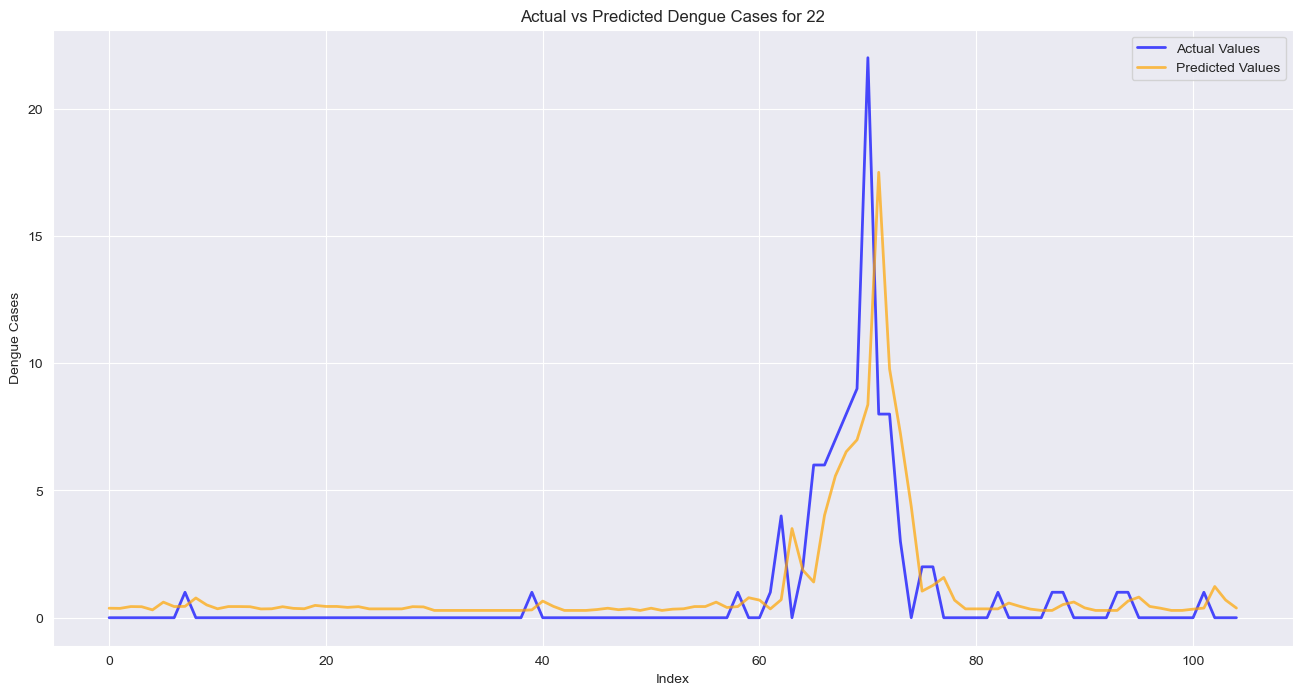

City: 24, RMSE: 4.102067701932898


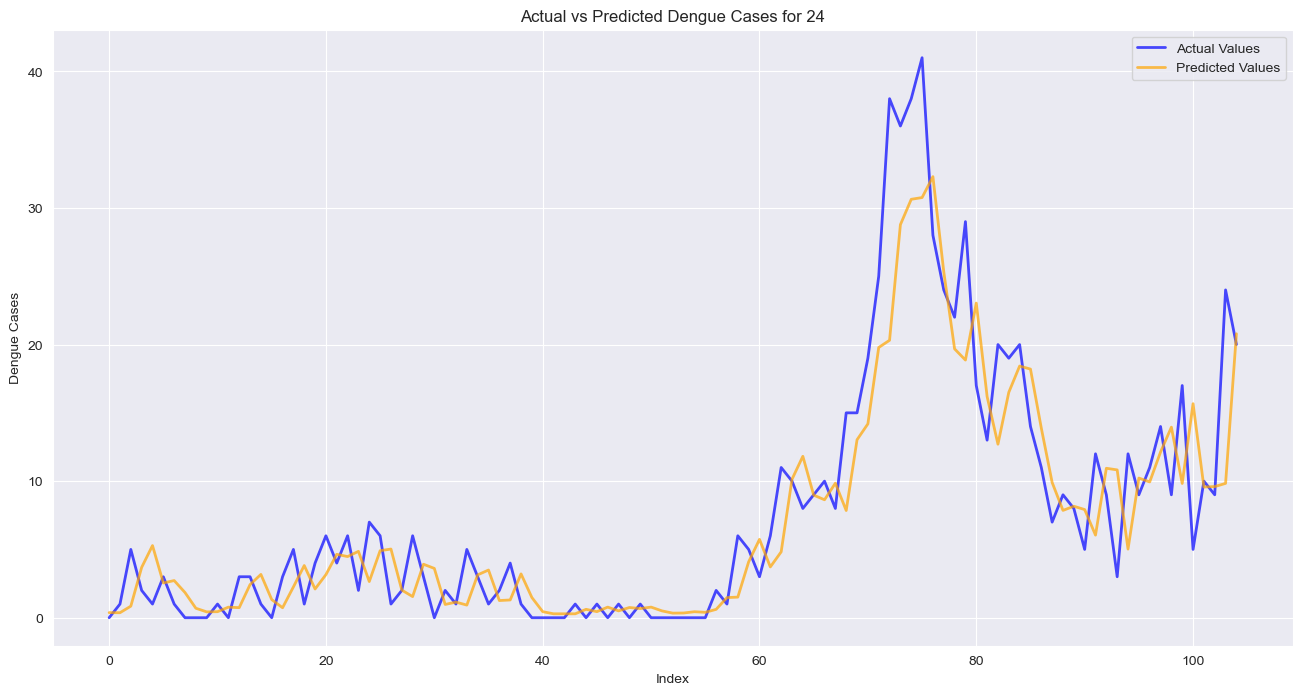

City: 27, RMSE: 3.4915005026009376


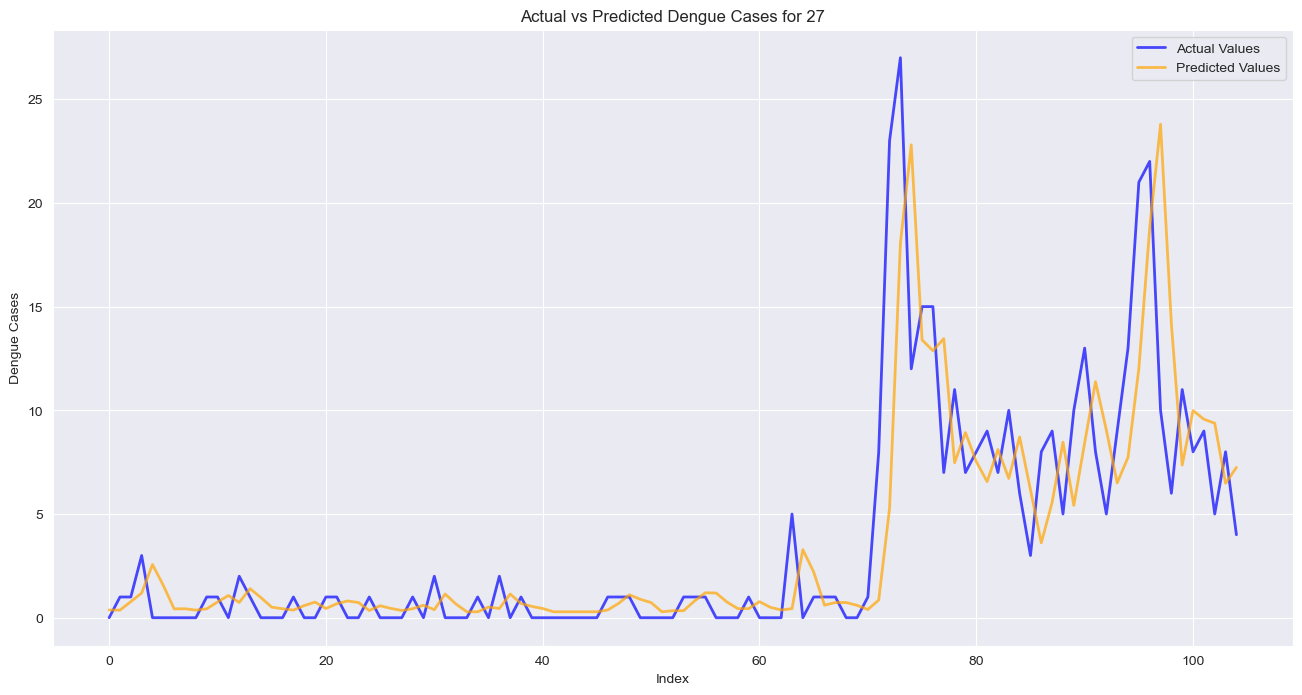

City: 28, RMSE: 2.0349040807403593


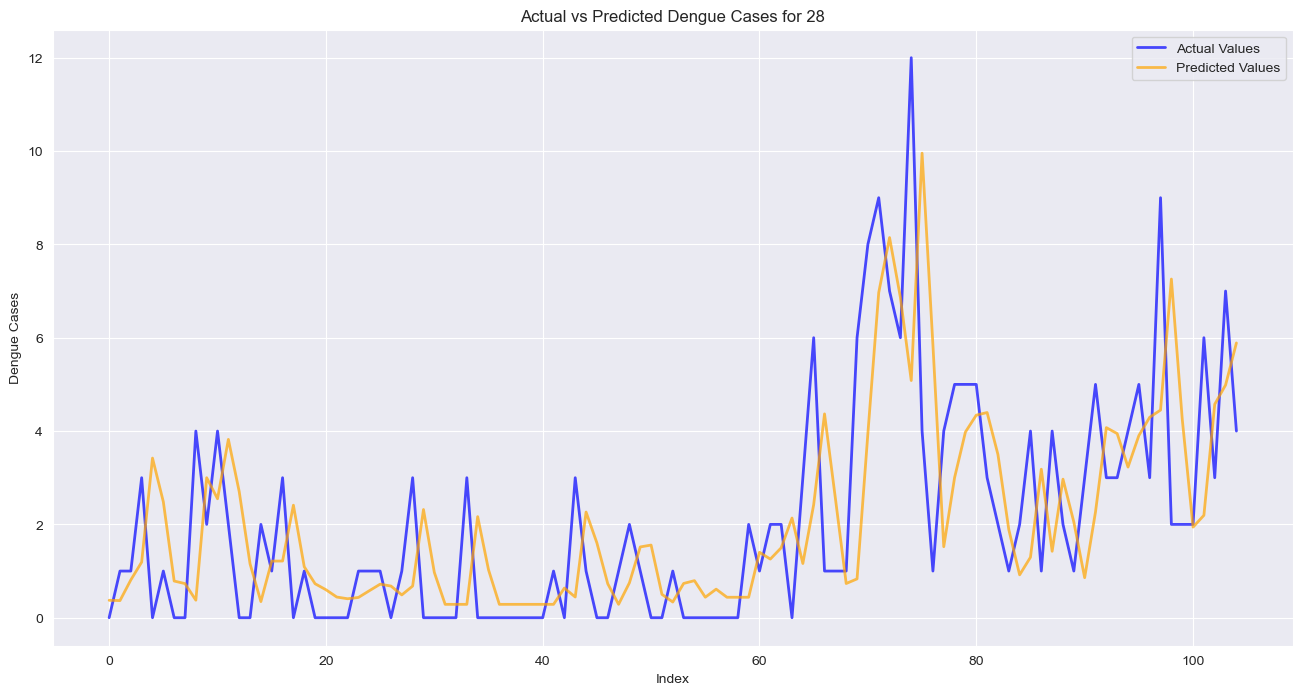

City: 29, RMSE: 5.212179795480269


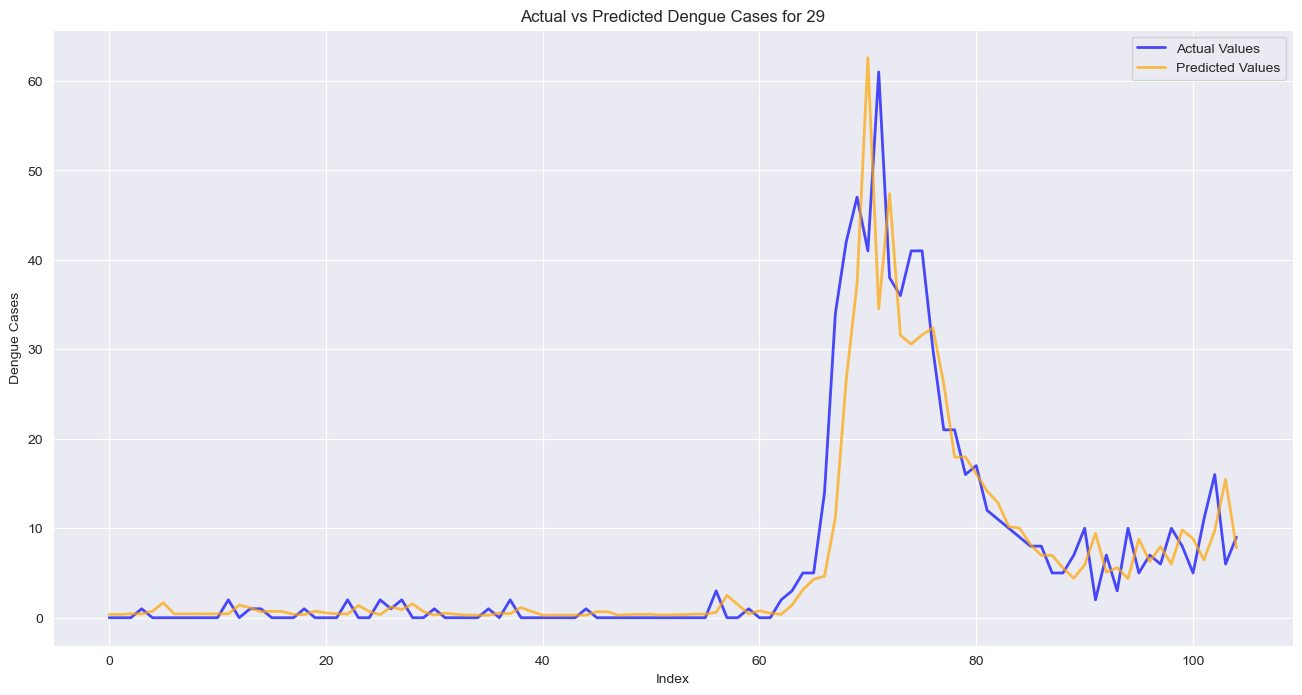

City: 30, RMSE: 1.8811443551412494


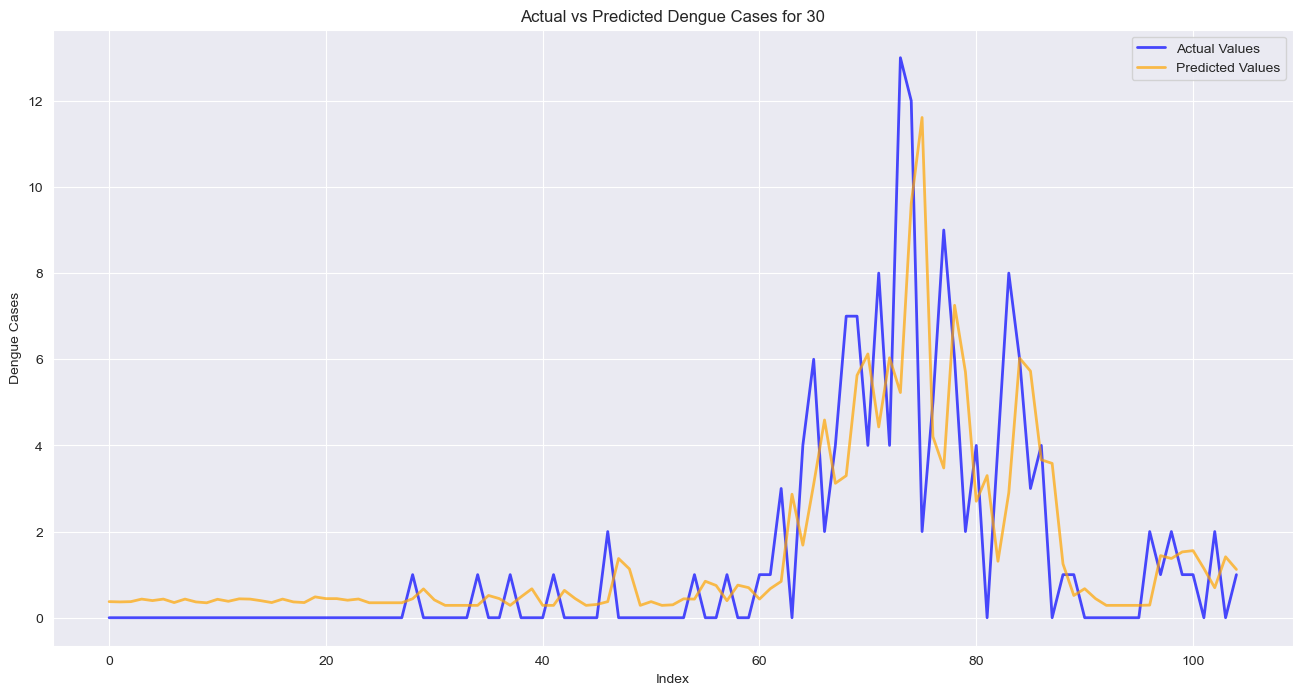

City: 31, RMSE: 3.9199862653862563


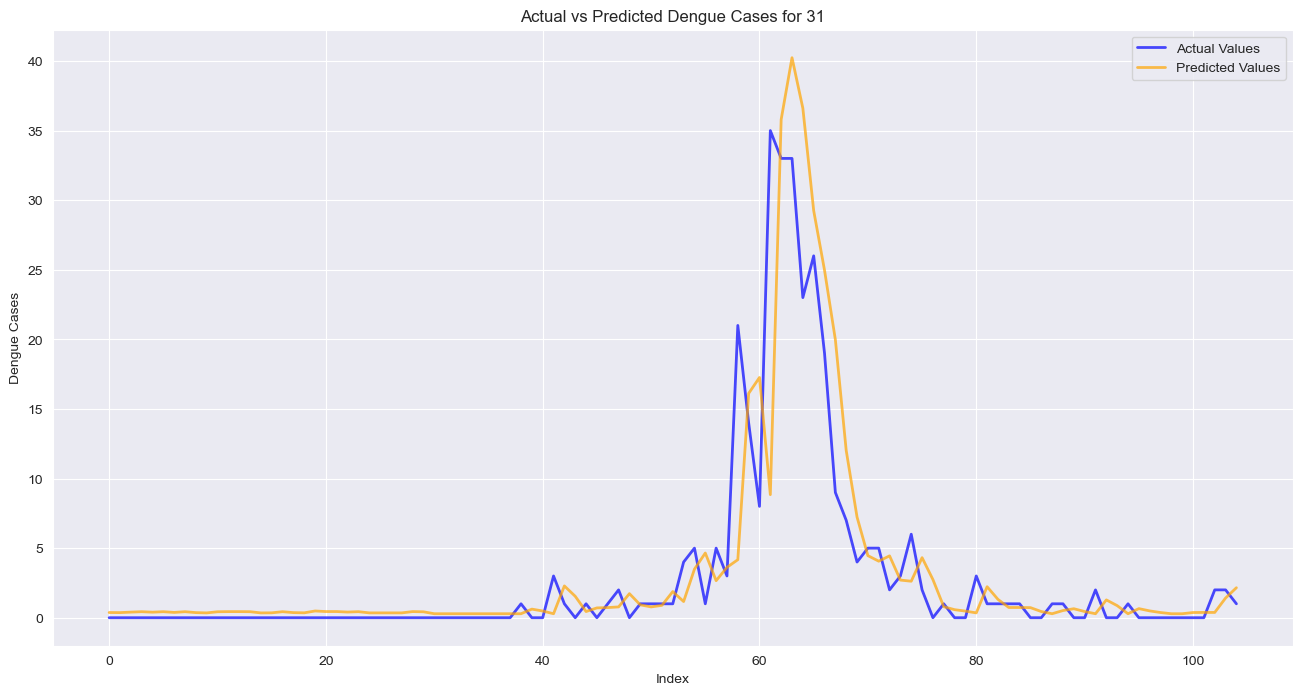

City: 32, RMSE: 7.077208397350697


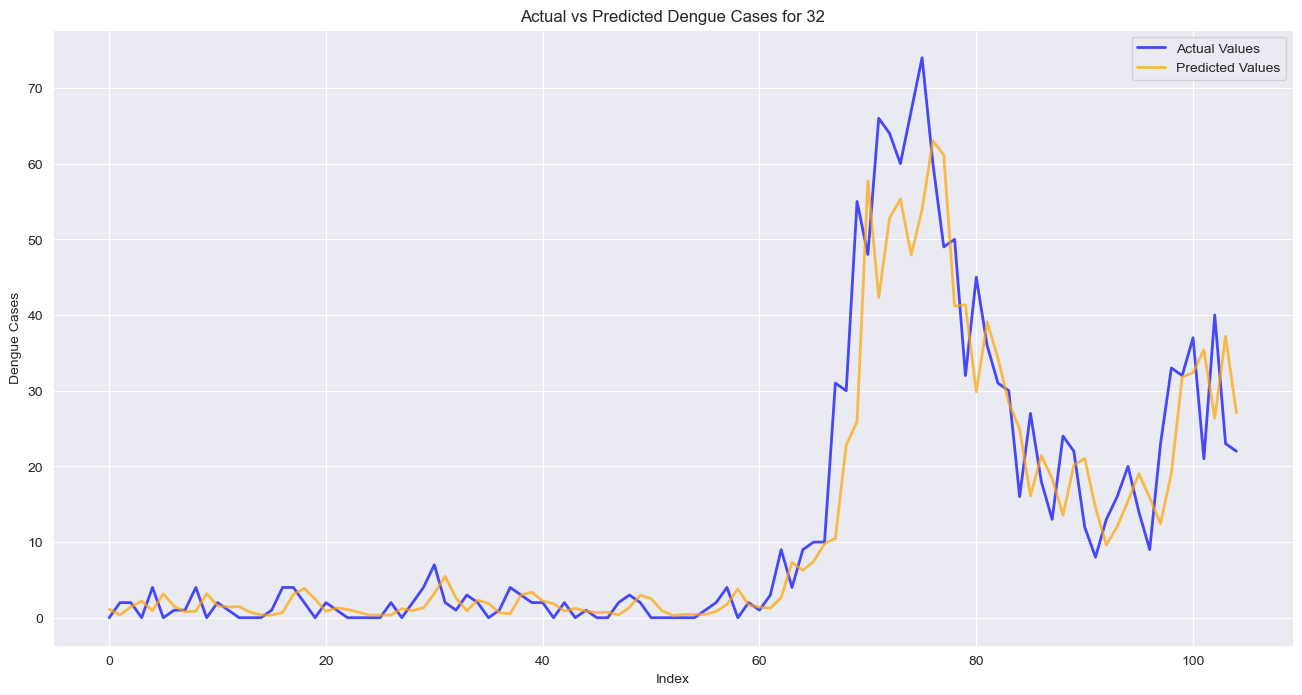

City: 34, RMSE: 1.992160062383691


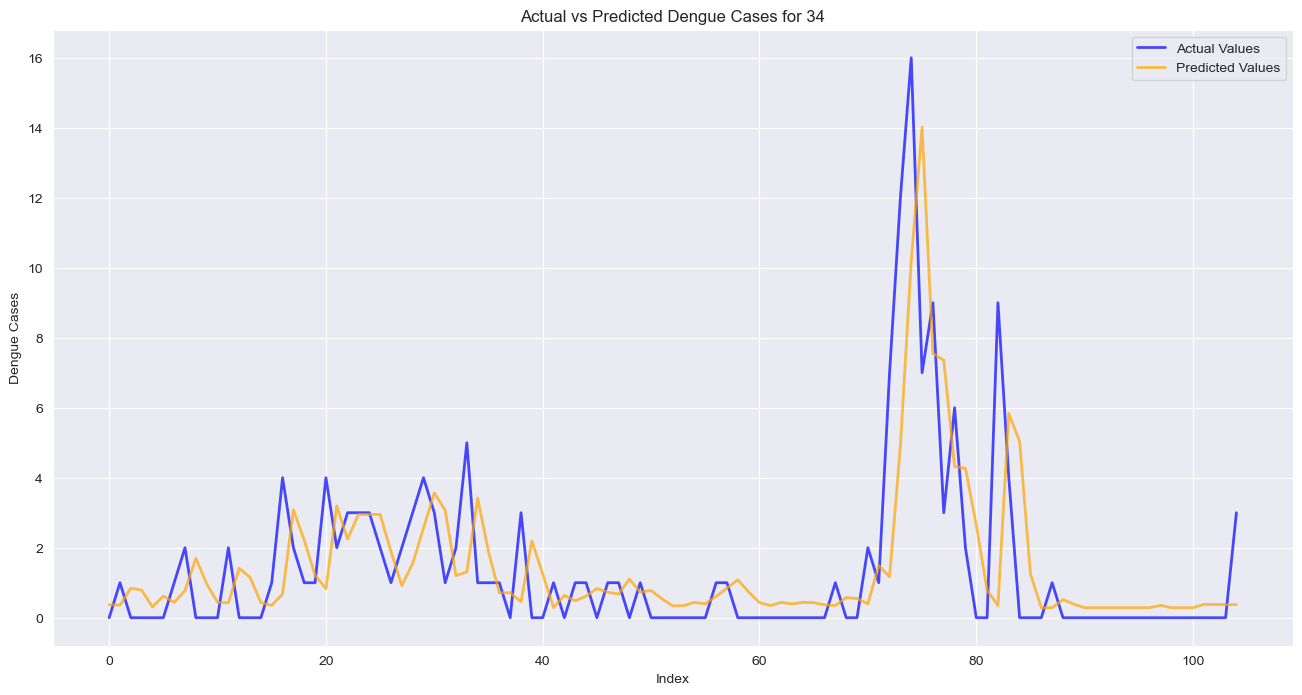

City: 36, RMSE: 8.533856987446761


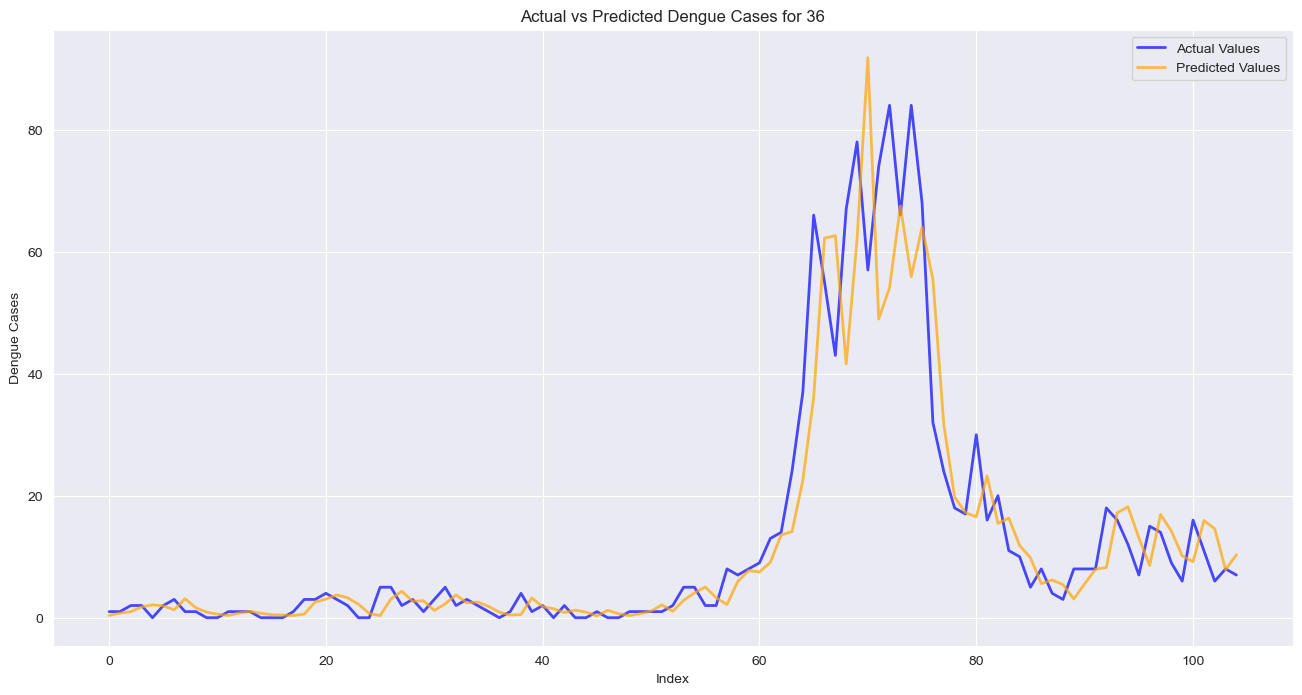

City: 38, RMSE: 1.5816052510293044


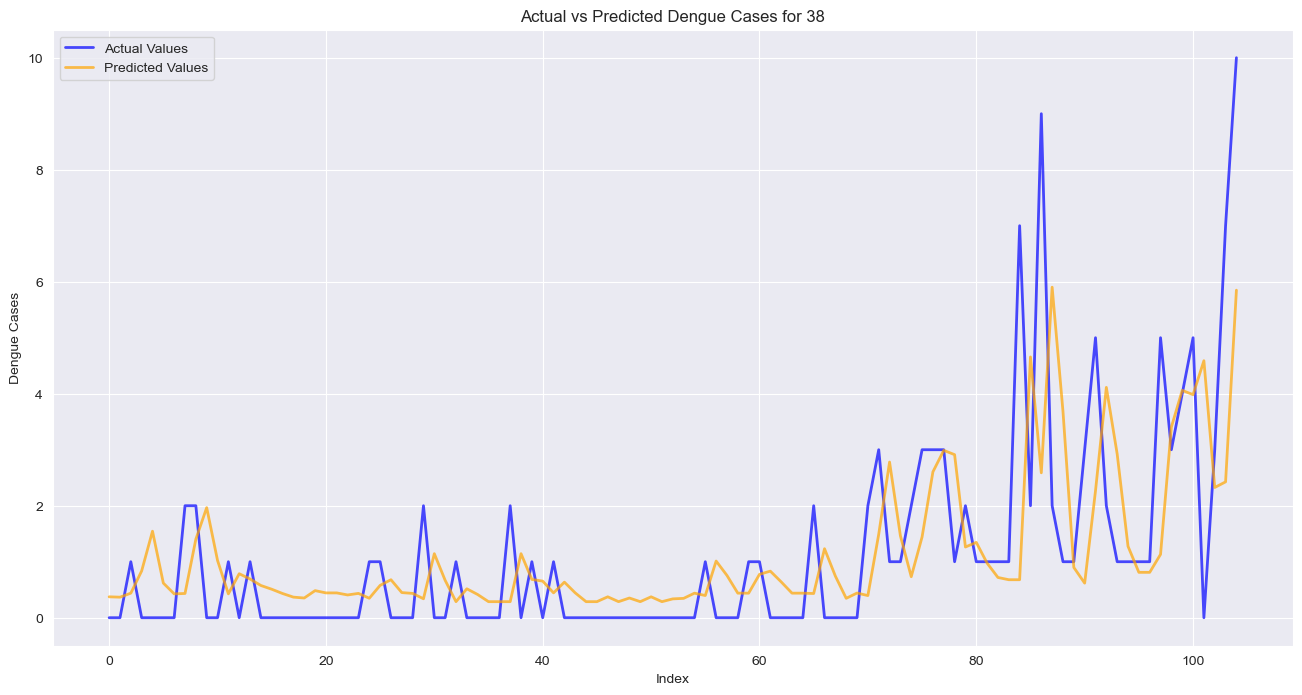

City: 47, RMSE: 3.572937839539271


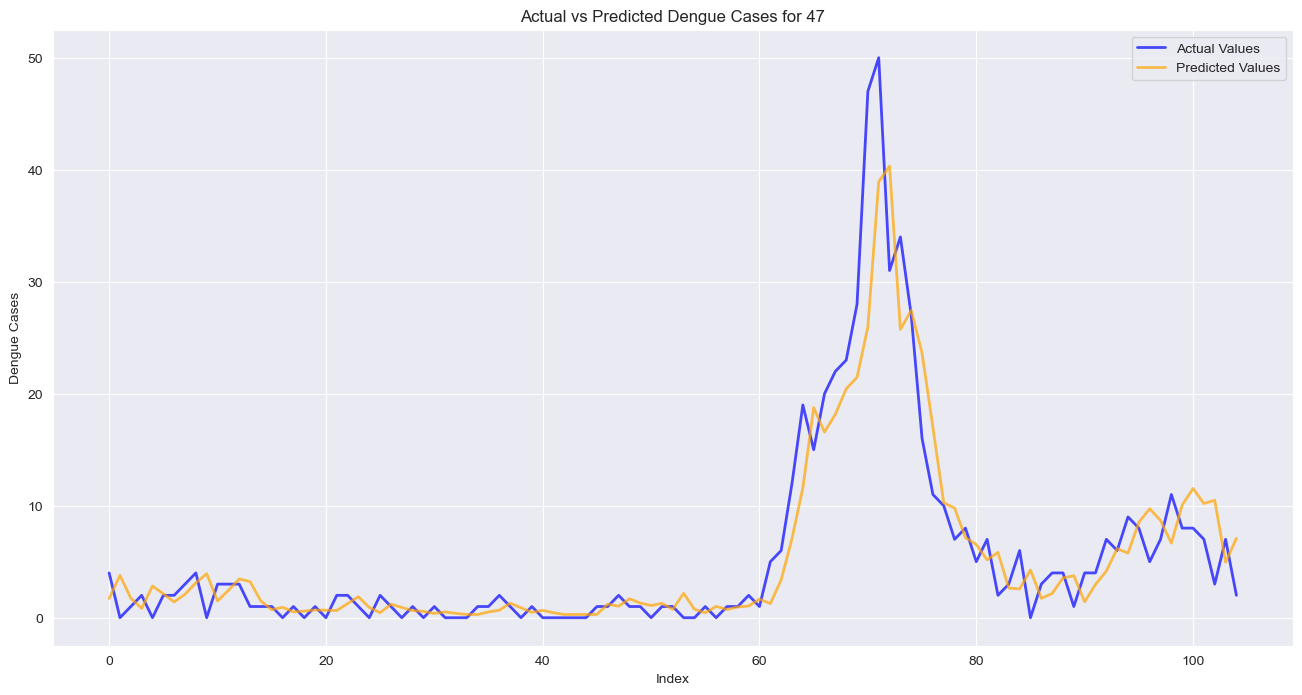

City: 48, RMSE: 2.7013620134489975


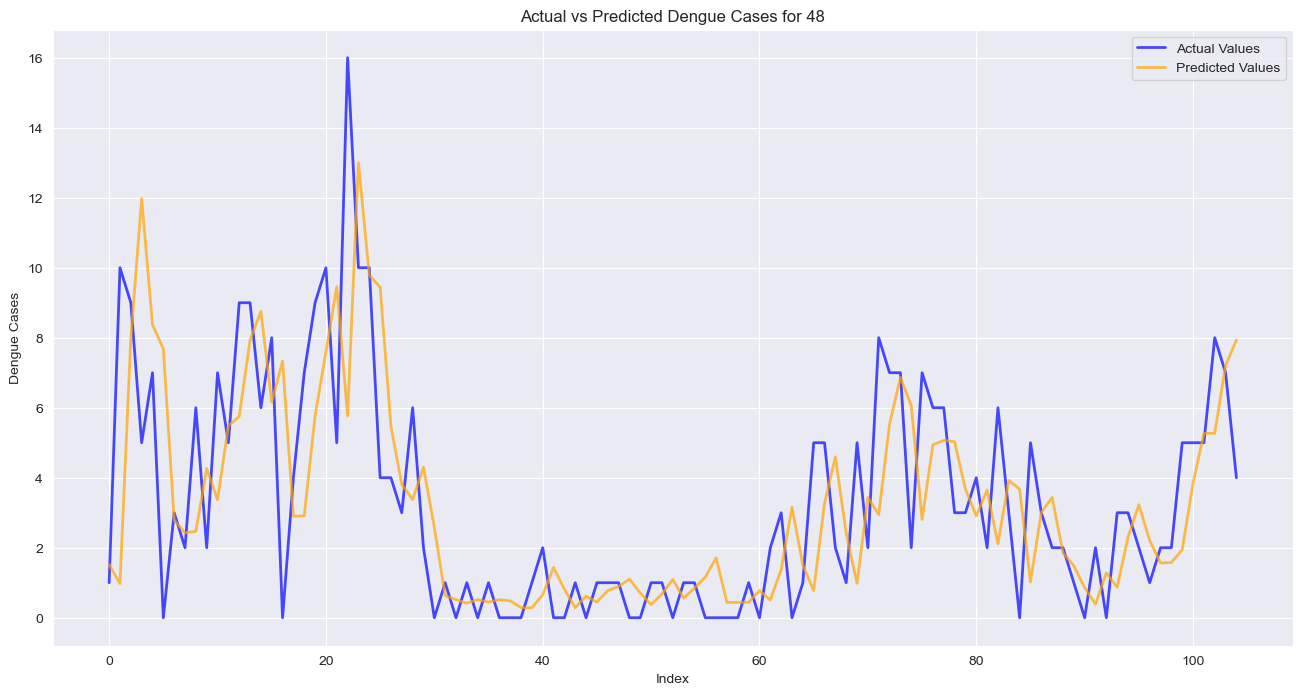

City: 50, RMSE: 4.628891152520234


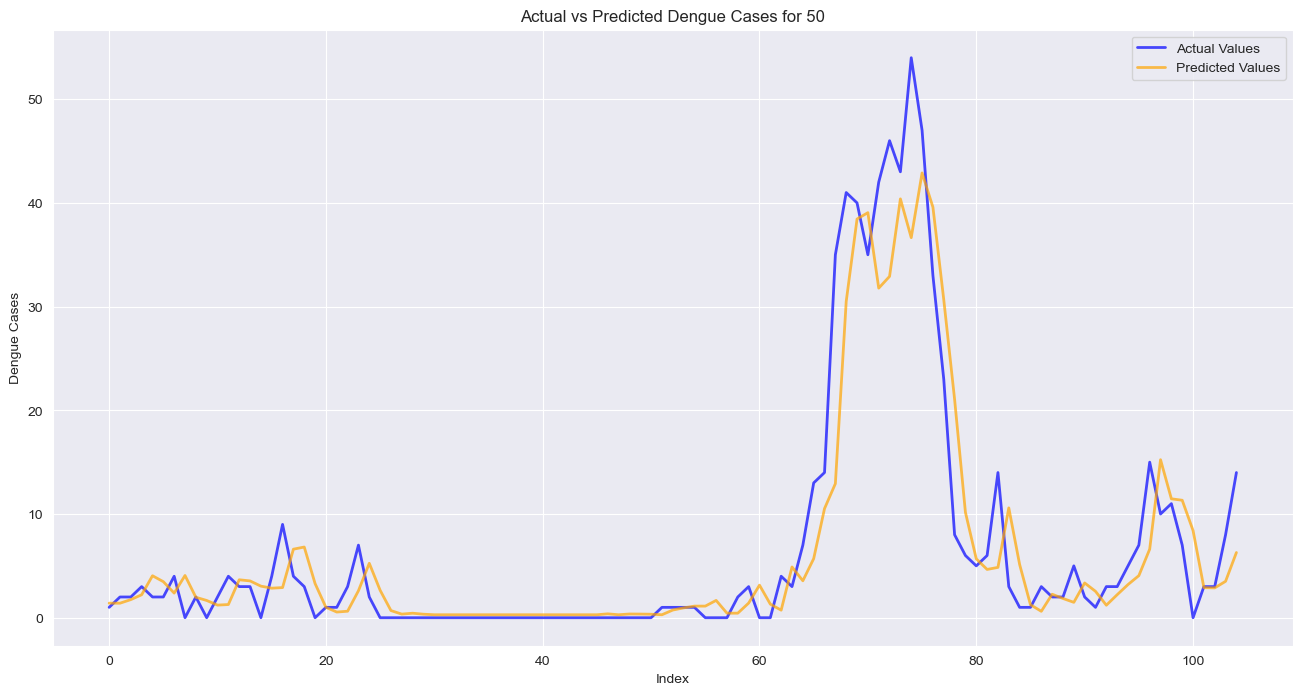

City: 53, RMSE: 1.601752031551049


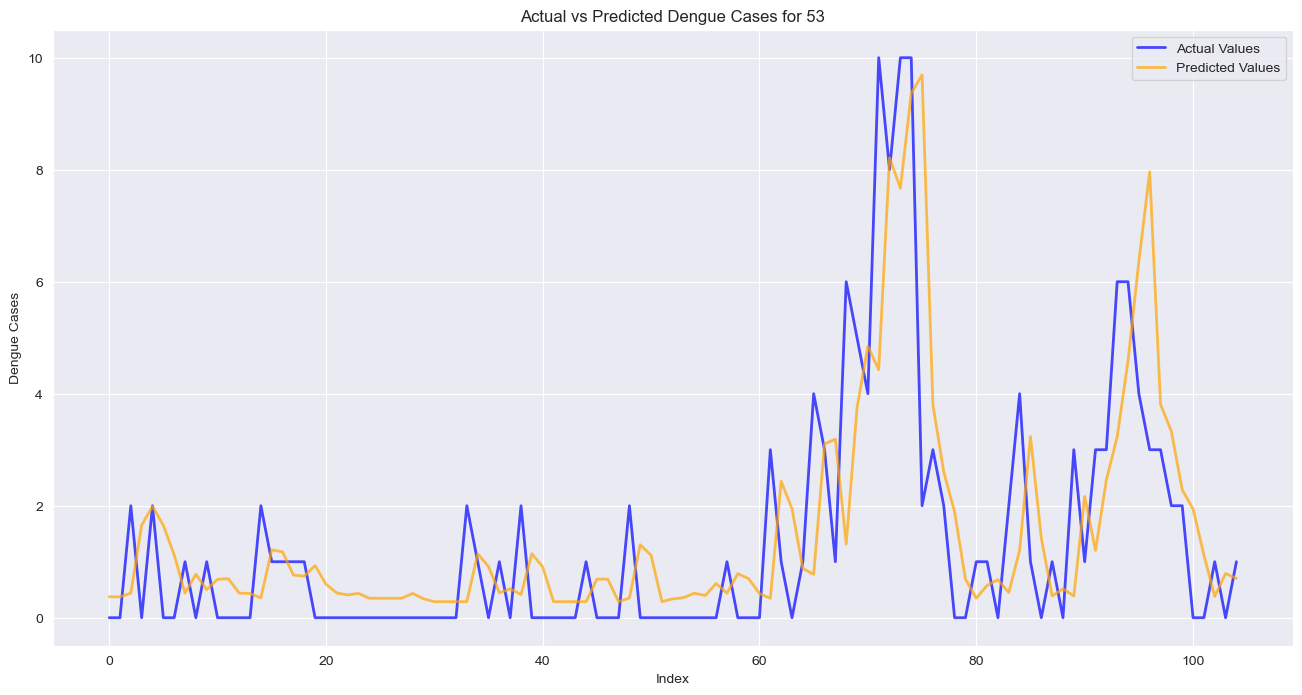

City: 55, RMSE: 2.1197739717036854


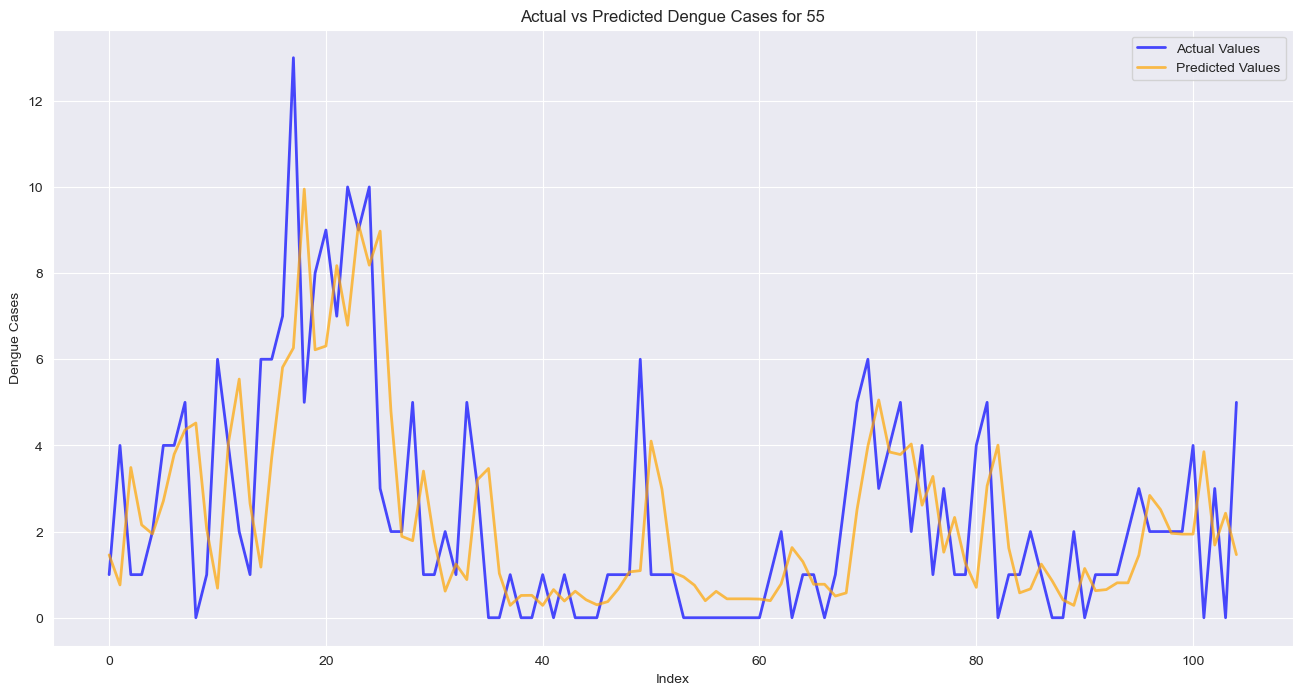

City: 56, RMSE: 3.3665737678463636


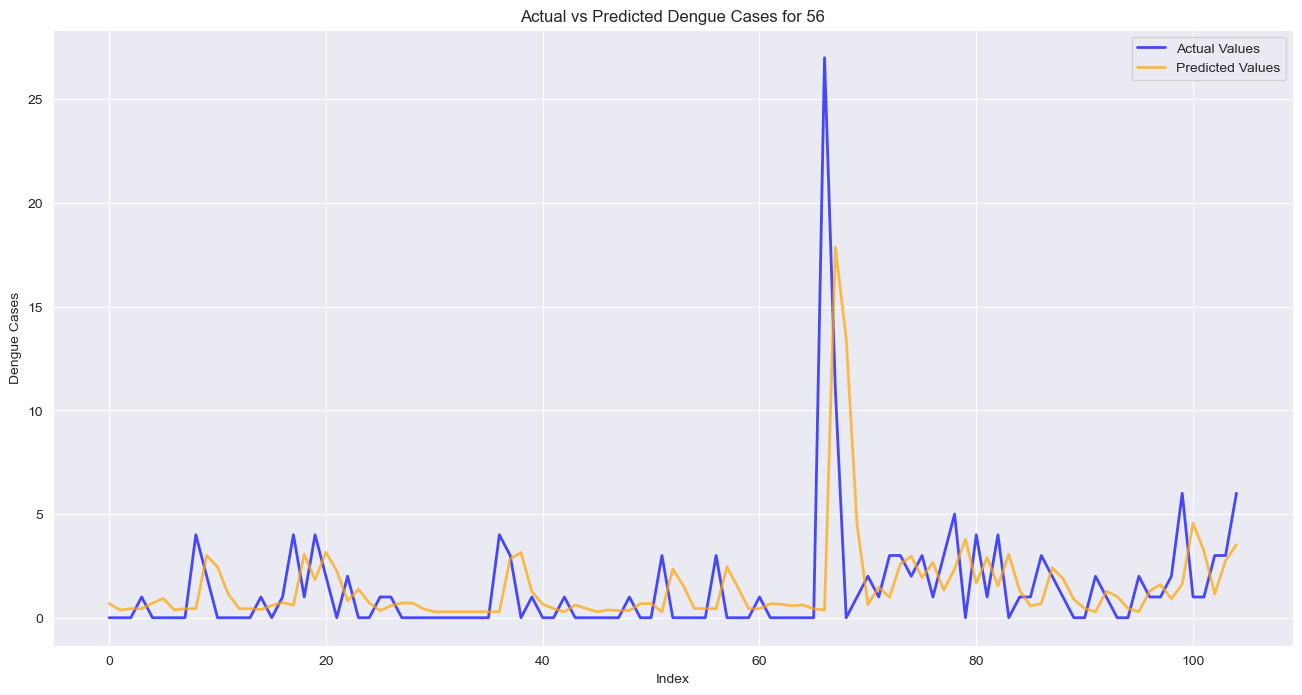

City: 58, RMSE: 2.0516914750101867


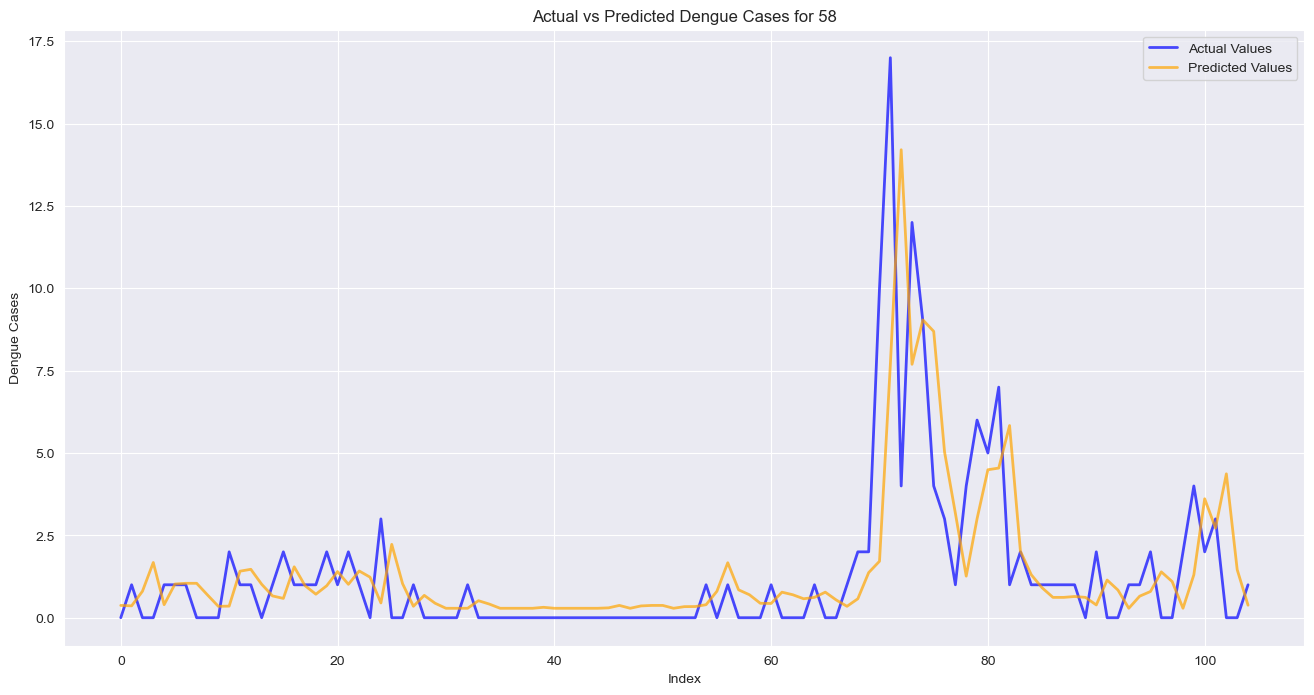

City: 60, RMSE: 2.472630379361439


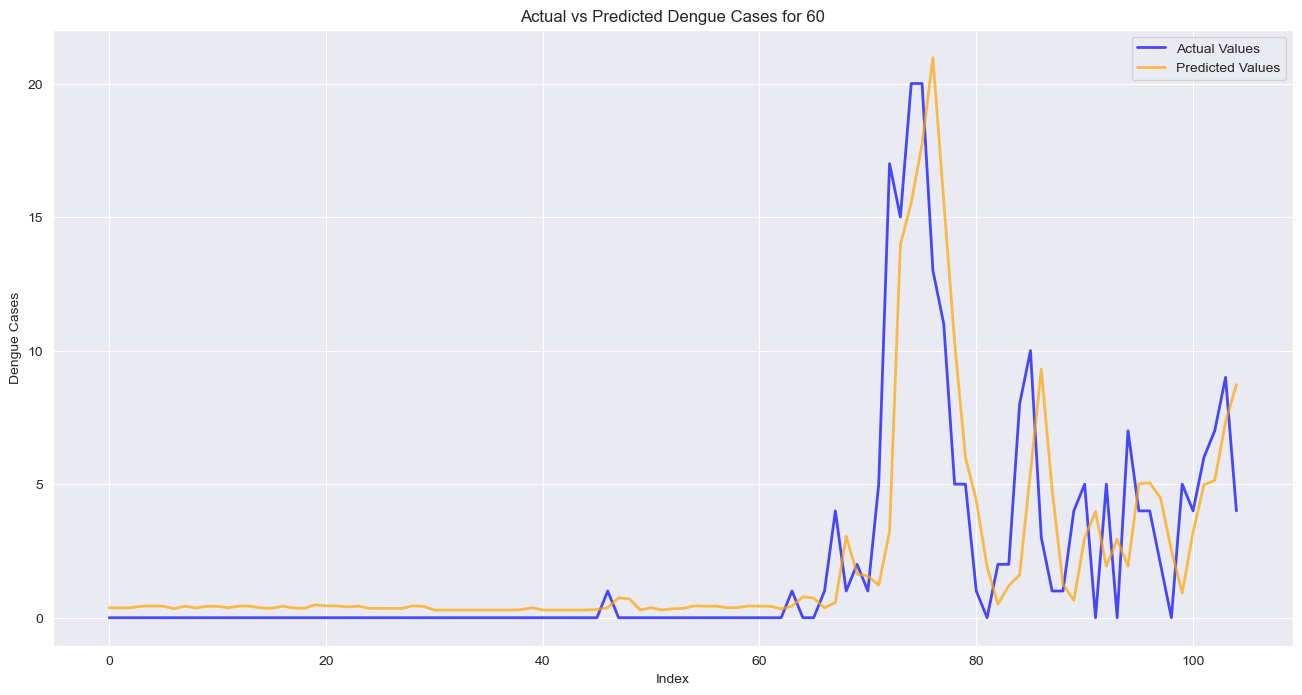

City: 61, RMSE: 8.801265693916433


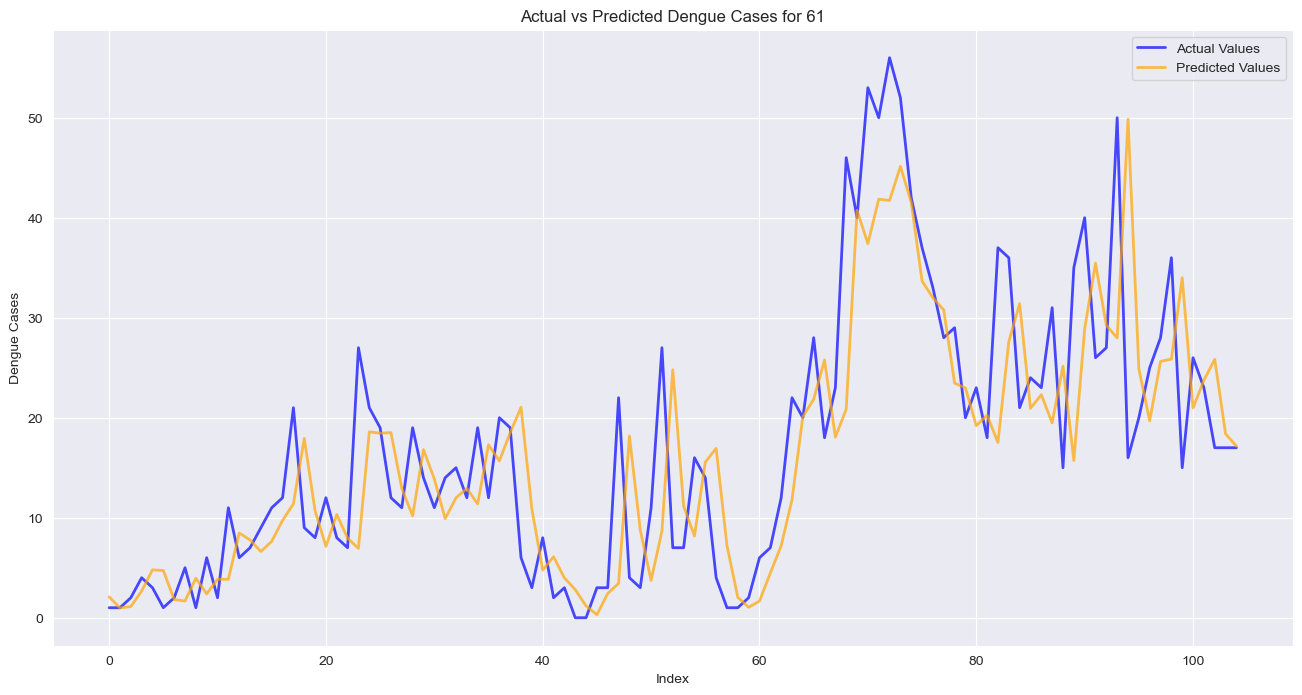

City: 65, RMSE: 5.534926819338277


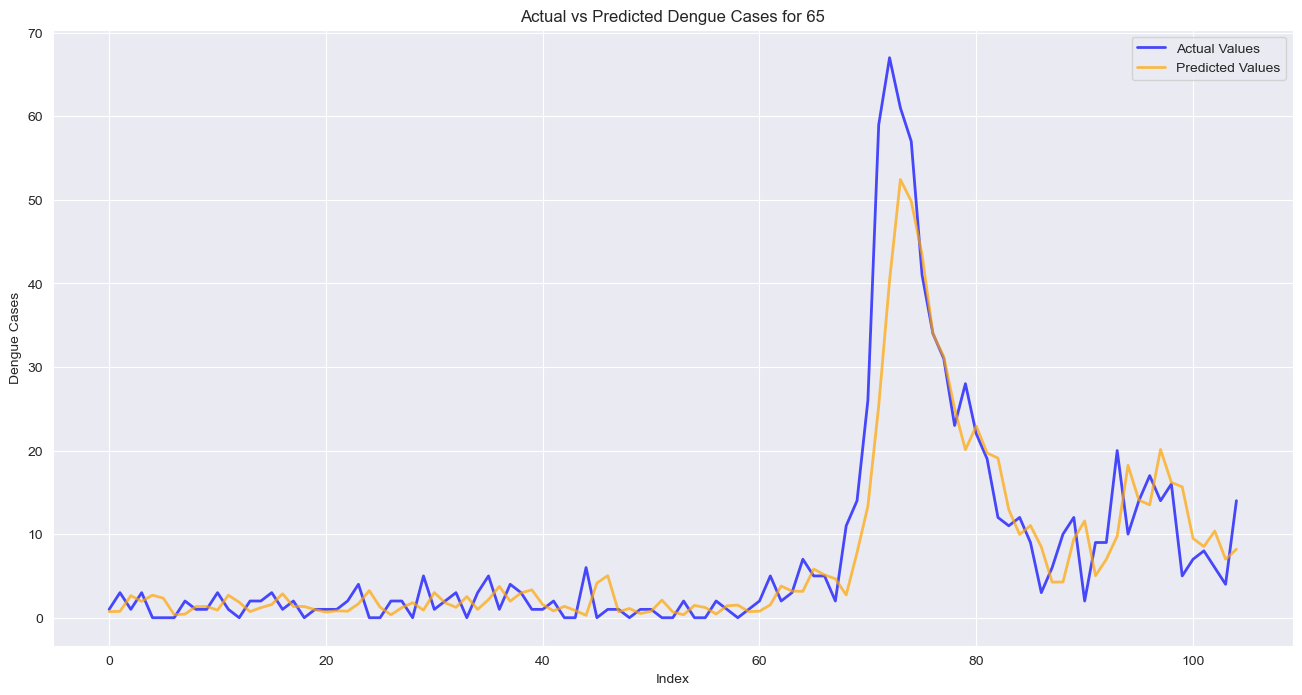

City: 66, RMSE: 26.917526080629184


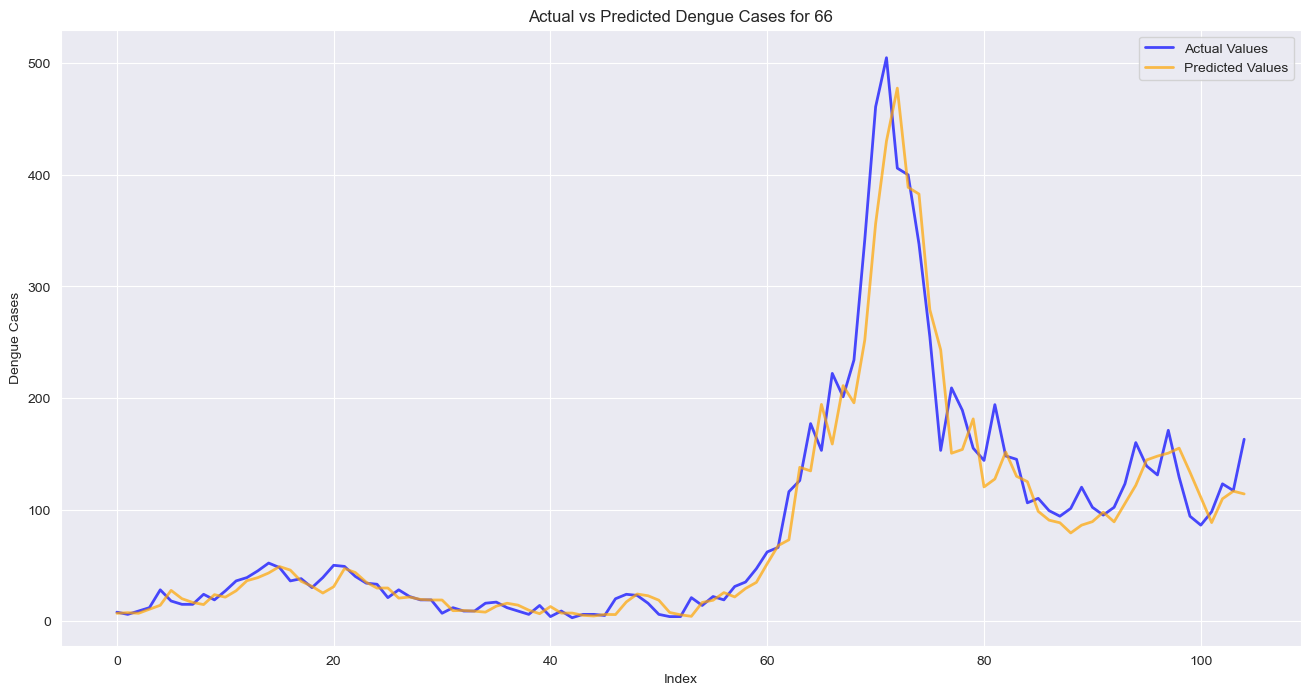

City: 68, RMSE: 5.088324595598775


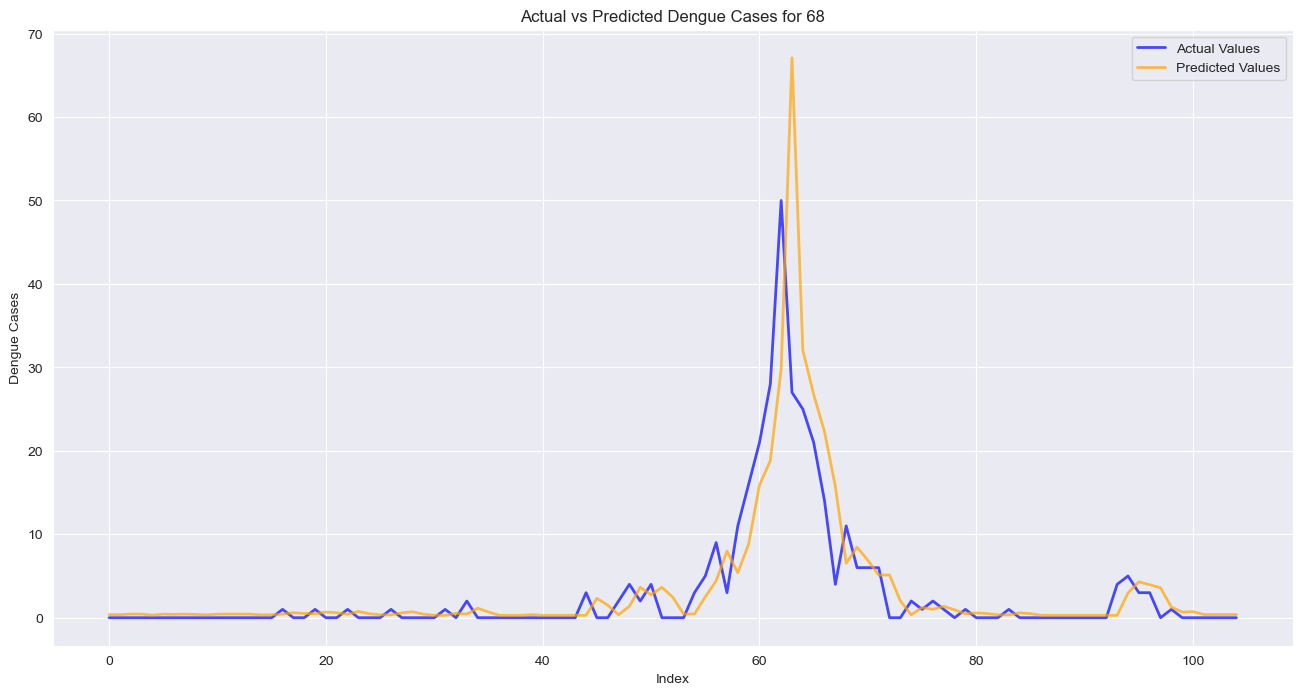

City: 76, RMSE: 2.2629204698869643


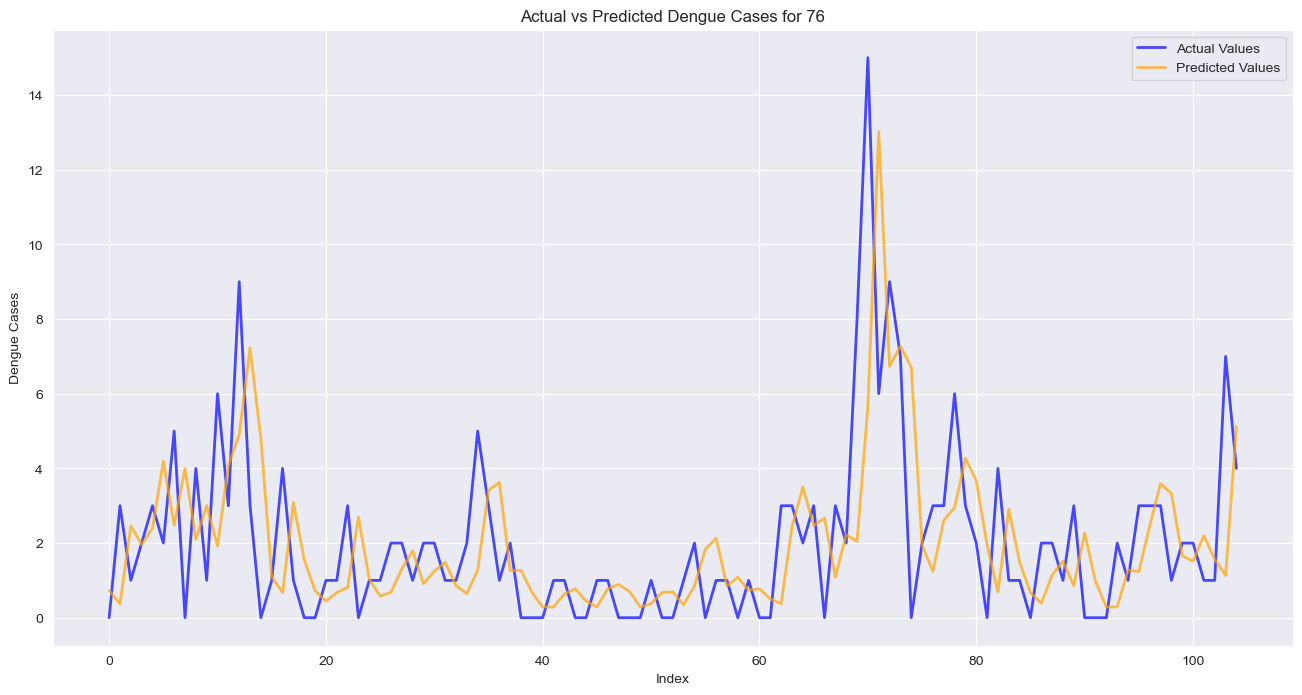

City: 80, RMSE: 2.3035999168533543


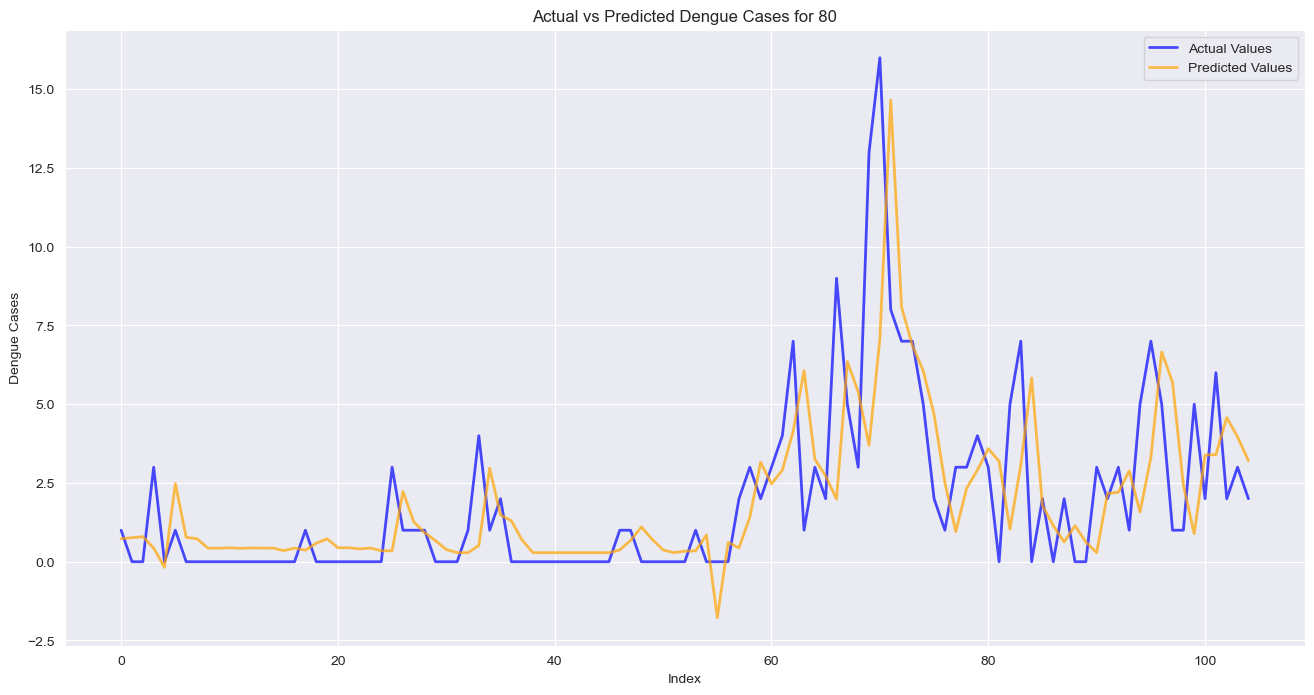

City: 81, RMSE: 1.607322774658387


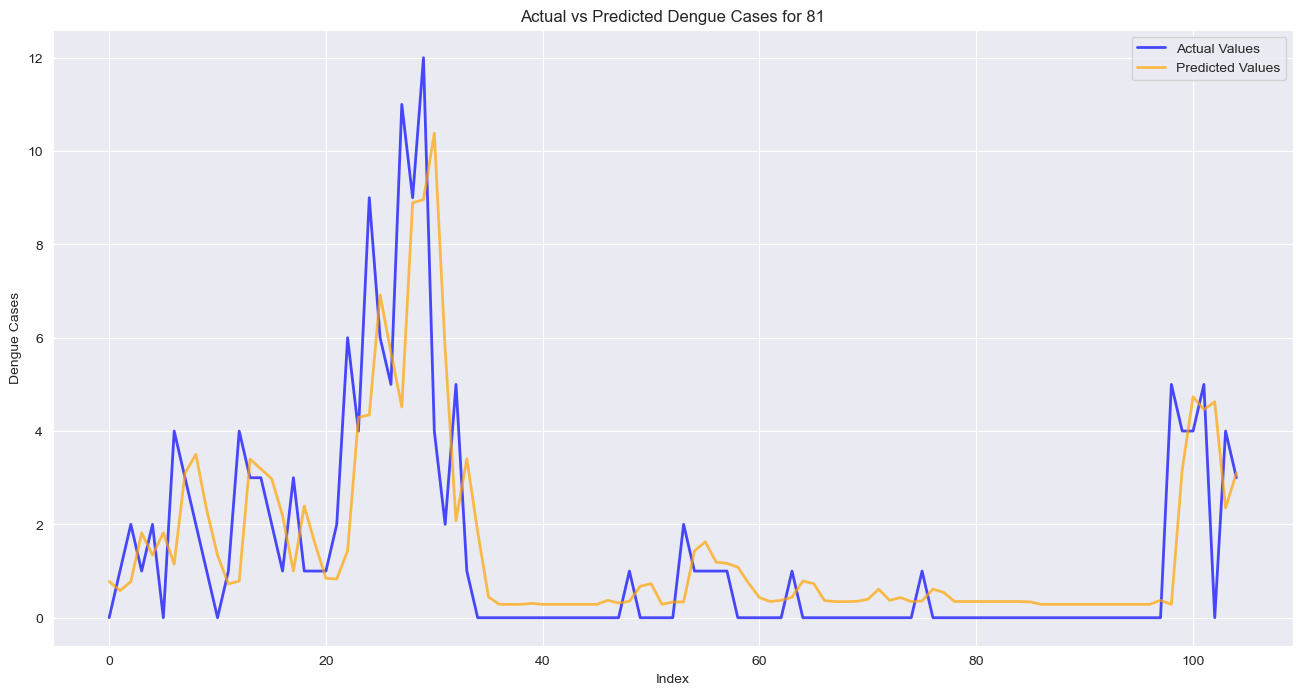

City: 70, RMSE: 3.3834430386978345


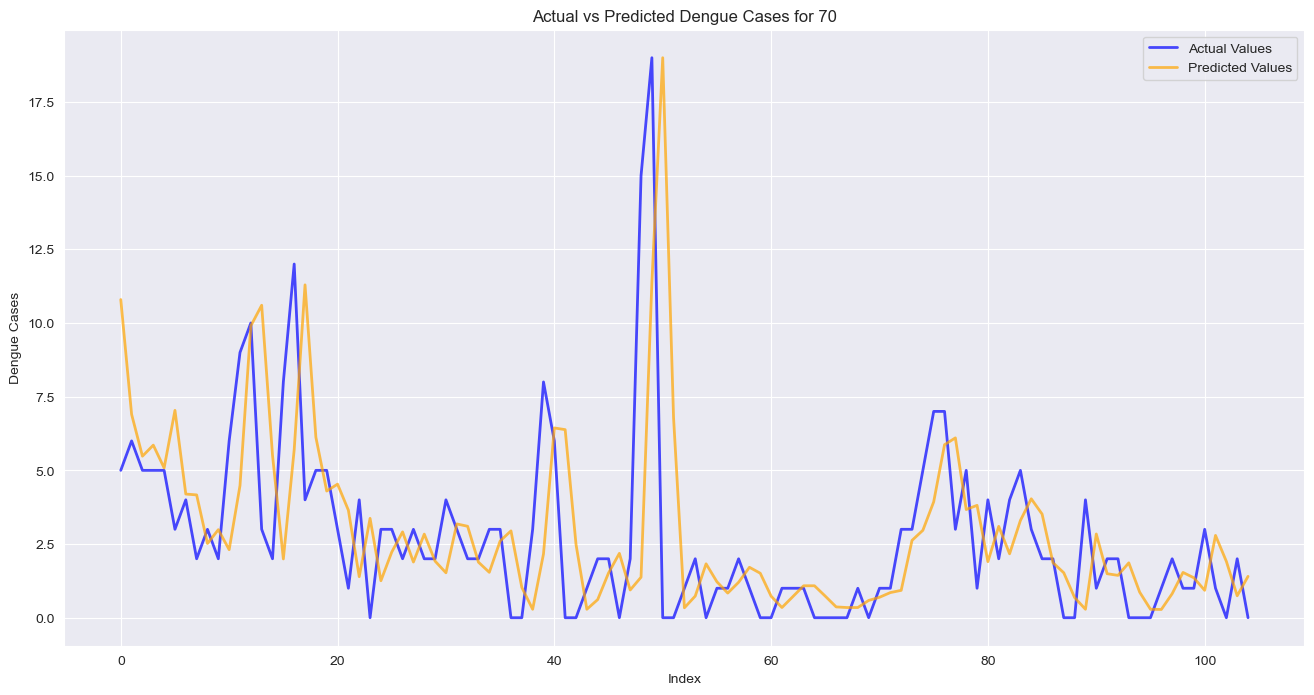

City: 71, RMSE: 2.6023149680118554


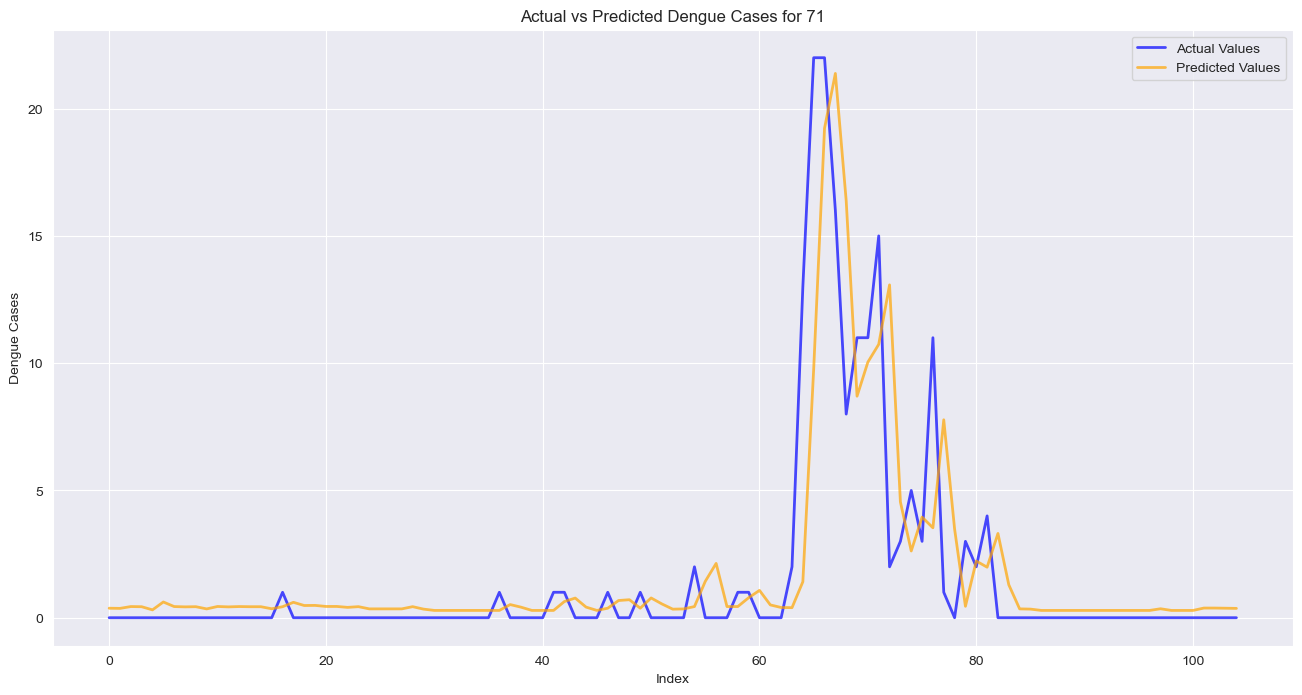

City: 87, RMSE: 2.006162561708481


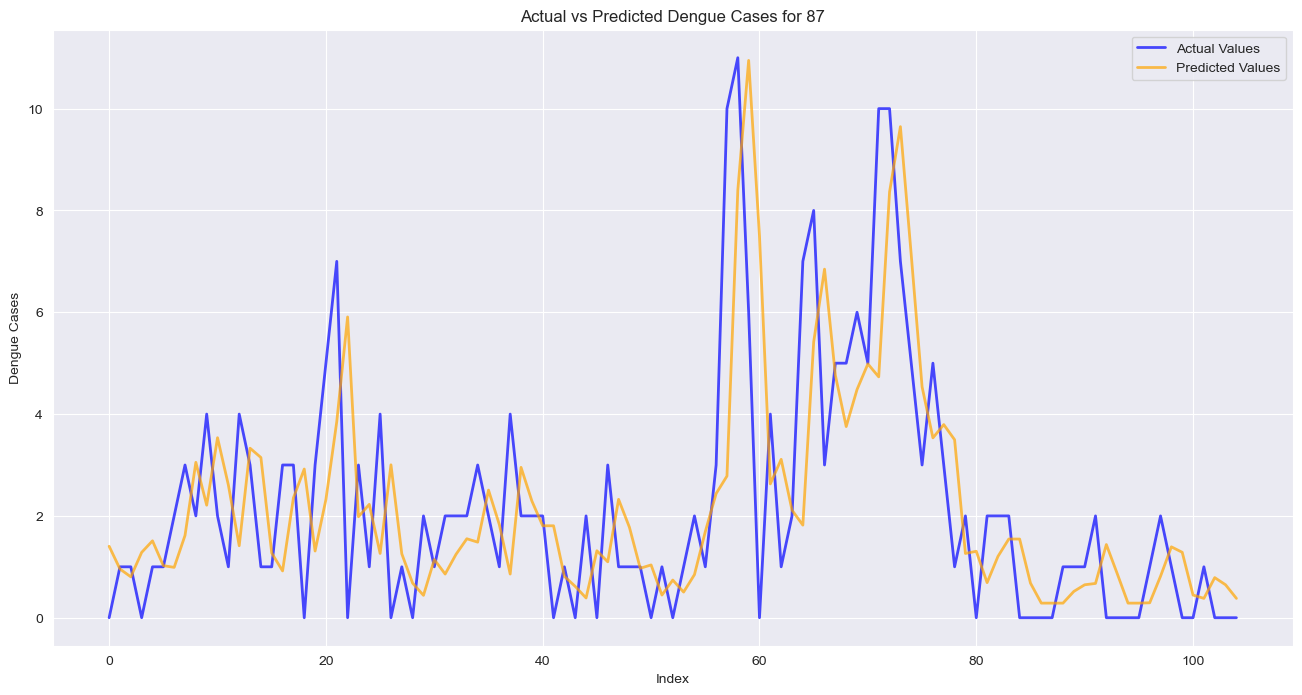

City: 89, RMSE: 2.16573356434019


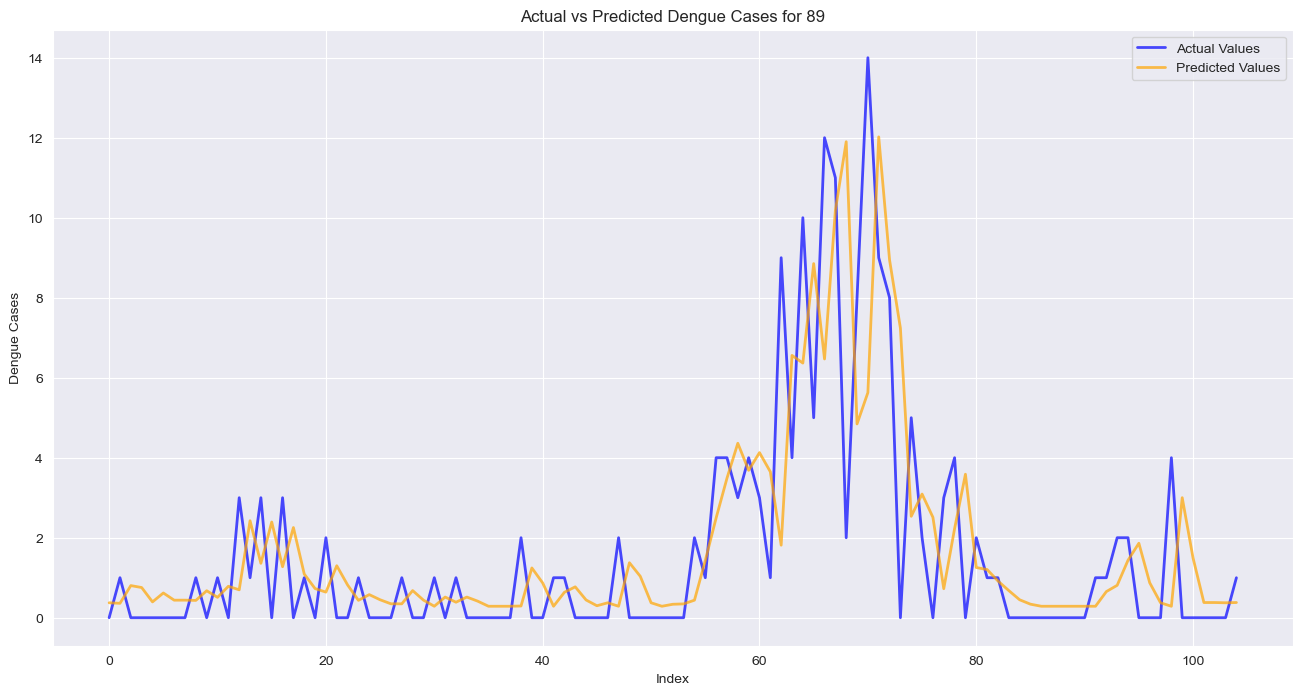

City: 90, RMSE: 2.42313163040363


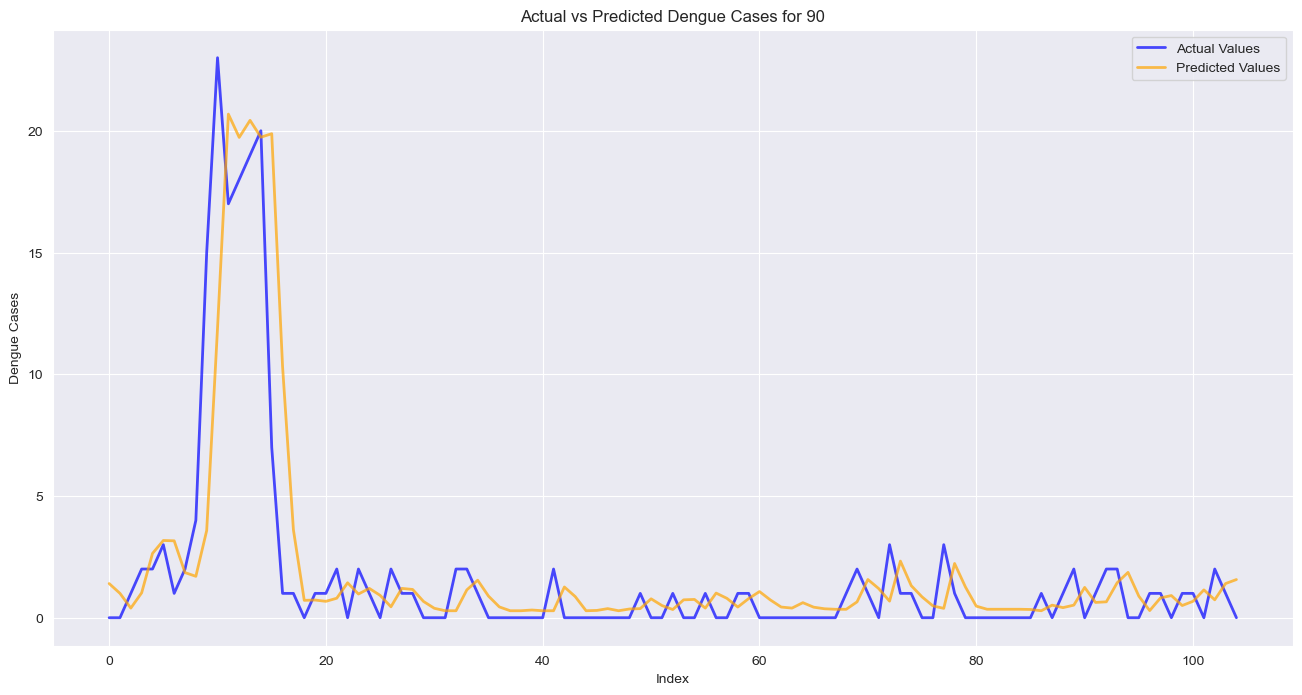

In [89]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'city' is present in X_test
cities = X_test['city_encoded'].unique()

# Iterate over each city
for city in cities:
    # Filter data for the city
    city_indices = X_test['city_encoded'] == city
    y_actual_city = target_scaler.inverse_transform(y_test[city_indices].values.reshape(-1, 1))
    y_pred_city = y_pred[city_indices]

    # Skip the city if the maximum actual dengue cases are less than 10
    if np.max(y_actual_city) < 10:
        continue

    # Apply ceiling operation to the predicted values
    # y_pred_city = np.ceil(y_pred_city)  # This will round up values like 2.4 to 3

    # Compute RMSE for the city
    rmse_city =  np.sqrt(mean_squared_error(y_actual_city, y_pred_city))
    print(f'City: {city}, RMSE: {rmse_city}')

    # Plot for the city
    plt.figure(figsize=(16, 8))
    plt.plot(np.arange(len(y_actual_city)), y_actual_city, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
    plt.plot(np.arange(len(y_pred_city)), y_pred_city, label='Predicted Values', color='orange', alpha=0.7, linewidth=2)
    plt.xlabel('Index')
    plt.ylabel('Dengue Cases')
    plt.title(f'Actual vs Predicted Dengue Cases for {city}')
    plt.legend()
    plt.grid(True)
    plt.show()
